# Interactive Latent-to-Shape Visualization (MLP VAE)

This notebook loads the trained VAE + DeepSDF models for **real labels** and **pseudo labels** and lets you interactively adjust each latent dimension to see the output shape.

- Initial slider values are set to the mean of the saved 8D latents.
- Slider ranges are derived from the min/max of the saved latents.
- Use the **Render** button (or enable Auto Update) to regenerate the mesh.


In [25]:
import os
import json
import numpy as np
import torch
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
from ipywidgets import (
    FloatSlider, IntSlider, Dropdown, Button, VBox, HBox, Label, Output, Checkbox
)
from IPython.display import display, clear_output, HTML
from skimage import measure
import trimesh

from networks import deep_sdf_decoder
from networks import residual_mlp_vae
import deep_sdf.workspace as ws
import deep_sdf.utils as sdf_utils
import train_MLP_VAE_deep_sdf as train_vae

torch.set_grad_enabled(False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

try:
    import anywidget as _anywidget  # noqa: F401
    _HAS_ANYWIDGET = True
except Exception:
    _HAS_ANYWIDGET = False
    print("anywidget not found; view persistence disabled (install anywidget to keep camera view).")

try:
    import nbformat as _nbformat
    _HAS_NBFORMAT = True
except Exception:
    _HAS_NBFORMAT = False
    print("nbformat not found; using HTML renderer for Plotly.")

def display_plotly(fig):
    if _HAS_NBFORMAT:
        display(fig)
    else:
        display(HTML(fig.to_html(include_plotlyjs="cdn")))


Using device: cuda
anywidget not found; view persistence disabled (install anywidget to keep camera view).


In [27]:
# Update these paths if your experiment folders are elsewhere.
EXPERIMENTS = {
    "real_label": "examples/ADNI/MLP_VAE_SDF_disentangle_all_true_label_age",
    "pseudo_label": "examples/ADNI/MLP_VAE_SDF_disentangle_pseudo_label_with_age",
}

MODEL_FILENAME = "latest.pth"
LATENTS_FILENAME = "latest.pth"

In [28]:
def load_specs(exp_dir):
    specs_path = os.path.join(exp_dir, "specs.json")
    with open(specs_path, "r") as f:
        return json.load(f)


def build_models(specs):
    code_len = specs["CodeLength"]
    sdf_decoder = deep_sdf_decoder.Decoder(code_len, **specs["NetworkSpecs"])
    vae = residual_mlp_vae.ResidualMLPVAE(
        input_dim=specs.get("VAEInputDim", code_len),
        latent_dim=specs.get("VAELatentDim", 8),
        encoder_hidden_dims=specs.get("VAEEncoderHiddenDims", [256, 128]),
        decoder_hidden_dims=specs.get("VAEDecoderHiddenDims", [128, 256, 256]),
        num_blocks=specs.get("VAEBlocks", 1),
        activation=specs.get("VAEActivation", "gelu"),
        dropout=specs.get("VAEDropout", 0.0),
        use_layernorm=specs.get("VAELayerNorm", True),
        use_kl=specs.get("UseKLLoss", True),
    )
    return vae, sdf_decoder


def load_models(exp_dir, device):
    specs = load_specs(exp_dir)
    vae, sdf_decoder = build_models(specs)
    epoch = train_vae.load_model(exp_dir, MODEL_FILENAME, vae, sdf_decoder)
    vae.to(device).eval()
    sdf_decoder.to(device).eval()
    return specs, vae, sdf_decoder, epoch


def load_latents(exp_dir):
    latent_path = os.path.join(exp_dir, "LatentCodes", LATENTS_FILENAME)
    latents = train_vae.load_latent_codes_from_file(latent_path)
    if isinstance(latents, dict):
        keys = sorted(latents.keys())
        latents = torch.stack([latents[k] for k in keys], dim=0)
    if isinstance(latents, torch.Tensor):
        if latents.dim() == 3 and latents.size(1) == 1:
            latents = latents[:, 0, :]
        return latents.float()
    raise ValueError("Unexpected latent format")


def latent_stats(latents):
    minv = latents.min(dim=0).values
    maxv = latents.max(dim=0).values
    meanv = latents.mean(dim=0)
    return minv, maxv, meanv


def create_mesh_from_decoder(decoder, latent_vec, N=64, max_batch=32768, device="cuda", return_sdf=False):
    decoder.eval()
    voxel_origin = [-1.0, -1.0, -1.0]
    voxel_size = 2.0 / (N - 1)

    overall_index = torch.arange(0, N ** 3, 1, dtype=torch.long)
    samples = torch.zeros(N ** 3, 4)
    samples[:, 2] = overall_index % N
    samples[:, 1] = (overall_index.long() / N) % N
    samples[:, 0] = ((overall_index.long() / N) / N) % N

    samples[:, 0] = (samples[:, 0] * voxel_size) + voxel_origin[2]
    samples[:, 1] = (samples[:, 1] * voxel_size) + voxel_origin[1]
    samples[:, 2] = (samples[:, 2] * voxel_size) + voxel_origin[0]

    num_samples = N ** 3
    head = 0
    while head < num_samples:
        end = min(head + max_batch, num_samples)
        sample_subset = samples[head:end, 0:3].to(device)
        with torch.no_grad():
            pred = sdf_utils.decode_sdf(decoder, latent_vec, sample_subset)
            pred = pred.squeeze(1).detach().cpu()
        samples[head:end, 3] = pred
        head = end

    sdf_values = samples[:, 3].reshape(N, N, N).numpy()

    try:
        verts, faces, normals, _ = measure.marching_cubes(
            sdf_values, level=0.0, spacing=[voxel_size] * 3, method="lewiner"
        )
    except ValueError as exc:
        print(f"Marching cubes failed: {exc}")
        if return_sdf:
            return None, None, None, None
        return None

    mesh_points = np.zeros_like(verts)
    mesh_points[:, 0] = voxel_origin[0] + verts[:, 0]
    mesh_points[:, 1] = voxel_origin[1] + verts[:, 1]
    mesh_points[:, 2] = voxel_origin[2] + verts[:, 2]

    mesh = trimesh.Trimesh(vertices=mesh_points, faces=faces, vertex_normals=normals, process=False)
    if return_sdf:
        return mesh, sdf_values, np.array(voxel_origin), voxel_size
    return mesh


def latent_to_mesh(z, vae, sdf_decoder, device, grid_n=64, max_batch=32768, return_sdf=False):
    z_tensor = torch.tensor(z, dtype=torch.float32, device=device).unsqueeze(0)
    with torch.no_grad():
        z_hat = vae.decoder(z_tensor)
    return create_mesh_from_decoder(
        sdf_decoder, z_hat, N=grid_n, max_batch=max_batch, device=device, return_sdf=return_sdf
    )


def volume_from_sdf(sdf_values, voxel_size):
    if sdf_values is None or voxel_size is None:
        return None
    inside = sdf_values < 0
    return float(np.sum(inside)) * (voxel_size ** 3)


def intensity_from_diff_grid(mesh, diff_grid, voxel_origin, voxel_size, denom=None, boost=1.0):
    """Sample a voxel-grid difference field at mesh vertices.

    Returns normalized intensity in [0, 1] using denom if provided.
    boost > 1.0 increases contrast toward high values (brighter yellow).
    """
    if mesh is None or diff_grid is None or voxel_origin is None or voxel_size is None:
        return None
    v = mesh.vertices
    idx = np.rint((v - voxel_origin) / voxel_size).astype(int)
    max_idx = np.array(diff_grid.shape) - 1
    idx = np.clip(idx, 0, max_idx)
    vals = diff_grid[idx[:, 0], idx[:, 1], idx[:, 2]]

    if vals.size == 0:
        return np.zeros((v.shape[0],), dtype=np.float32)

    if denom is None:
        denom = float(np.max(vals))
    denom = float(denom)
    if not np.isfinite(denom) or denom <= 1e-8:
        return np.zeros_like(vals, dtype=np.float32)

    vals = np.clip(vals / denom, 0.0, 1.0)
    try:
        b = float(boost)
    except Exception:
        b = 1.0
    if b > 0 and b != 1.0:
        vals = np.power(vals, 1.0 / b)

    return vals.astype(np.float32)


def _prepare_vertices(mesh, upright=False):
    v = mesh.vertices.copy()
    if upright:
        # Rotate +90 deg around X so Z becomes up (swap Y/Z).
        v = np.stack([v[:, 0], v[:, 2], -v[:, 1]], axis=1)
    return v


def _center_and_radius_from_meshes(meshes, upright=False, pad_frac=0.12):
    verts = []
    for m in meshes:
        if m is None:
            continue
        verts.append(_prepare_vertices(m, upright=upright))
    if not verts:
        center = np.zeros((3,), dtype=np.float32)
        r = 1.0
        return center, r

    v = np.concatenate(verts, axis=0)
    mi = np.min(v, axis=0)
    ma = np.max(v, axis=0)
    center = (mi + ma) / 2.0
    half = (ma - mi) / 2.0
    r = float(np.max(half))
    r = r * (1.0 + float(pad_frac))
    if not np.isfinite(r) or r <= 0:
        r = 1.0
    return center, r


VIEW_PRESETS = {
    'Side +X': dict(eye=(1.0, 0.0, 0.0), up=(0.0, 0.0, 1.0)),
    'Side -X': dict(eye=(-1.0, 0.0, 0.0), up=(0.0, 0.0, 1.0)),
    'Front +Y': dict(eye=(0.0, 1.0, 0.0), up=(0.0, 0.0, 1.0)),
    'Back -Y': dict(eye=(0.0, -1.0, 0.0), up=(0.0, 0.0, 1.0)),
    'Top +Z': dict(eye=(0.0, 0.0, 1.0), up=(0.0, 1.0, 0.0)),
    'Iso': dict(eye=(1.0, 1.0, 1.0), up=(0.0, 0.0, 1.0)),
}

LIGHT_PRESETS = {
    'Soft': dict(
        lighting=dict(ambient=0.7, diffuse=0.4, specular=0.1, roughness=0.9, fresnel=0.05),
        lightposition=dict(x=100, y=100, z=100),
    ),
    'Studio': dict(
        lighting=dict(ambient=0.4, diffuse=0.7, specular=0.2, roughness=0.6, fresnel=0.1),
        lightposition=dict(x=200, y=50, z=100),
    ),
    'Hard': dict(
        lighting=dict(ambient=0.2, diffuse=0.9, specular=0.3, roughness=0.4, fresnel=0.2),
        lightposition=dict(x=300, y=0, z=0),
    ),
    'Rim': dict(
        lighting=dict(ambient=0.2, diffuse=0.5, specular=0.8, roughness=0.2, fresnel=0.5),
        lightposition=dict(x=-200, y=200, z=100),
    ),
    'Matte': dict(
        lighting=dict(ambient=0.6, diffuse=0.6, specular=0.0, roughness=1.0, fresnel=0.0),
        lightposition=dict(x=100, y=0, z=200),
    ),
    'Glossy': dict(
        lighting=dict(ambient=0.3, diffuse=0.5, specular=0.9, roughness=0.1, fresnel=0.5),
        lightposition=dict(x=150, y=150, z=50),
    ),
}

YELLOW_SCALES = {
    'Bright': [
        [0.0, '#1f77b4'],
        [0.5, '#FFF9C4'],
        [1.0, '#FFEB3B'],
    ],
    'Deep': [
        [0.0, '#1f77b4'],
        [0.5, '#FFE082'],
        [1.0, '#FF8F00'],
    ],
    'Soft': [
        [0.0, '#1f77b4'],
        [0.5, '#FFFDE7'],
        [1.0, '#FFD54F'],
    ],
}

def _resolve_view_camera(preset, scale=1.2):
    cfg = VIEW_PRESETS.get(preset, VIEW_PRESETS['Side +X'])
    ex, ey, ez = cfg['eye']
    ux, uy, uz = cfg.get('up', (0.0, 0.0, 1.0))
    return dict(
        eye=dict(x=float(scale * ex), y=float(scale * ey), z=float(scale * ez)),
        up=dict(x=float(ux), y=float(uy), z=float(uz)),
    )

def _resolve_lighting(preset):
    cfg = LIGHT_PRESETS.get(preset, LIGHT_PRESETS['Studio'])
    return cfg['lighting'], cfg['lightposition']

def _resolve_colorscale(preset):
    return YELLOW_SCALES.get(preset, YELLOW_SCALES['Bright'])


def build_baselines_and_change_figure(
    base_min_mesh,
    base_max_mesh,
    change_mesh,
    intensity,
    title=None,
    upright=False,
    camera_z=1.4,
    camera=None,
    lighting=None,
    lightposition=None,
    colorscale=None,
    baseline_titles=None,
    change_title=None,
    baseline_left_mesh=None,
    baseline_right_mesh=None,
):
    """Top row: disease-min and disease-max baselines side-by-side.

    Bottom row: current mesh (solid) and current mesh with change map.
    """
    if baseline_left_mesh is None or baseline_right_mesh is None:
        baseline_left_mesh = base_min_mesh
        baseline_right_mesh = base_max_mesh
    if baseline_titles is None:
        baseline_titles = ('Baseline: disease min', 'Baseline: disease max')
    if change_title is None:
        change_title = 'Current: change map (blue=no change, yellow=more change)'

    left_v = _prepare_vertices(baseline_left_mesh, upright=upright)
    left_f = baseline_left_mesh.faces

    right_v = _prepare_vertices(baseline_right_mesh, upright=upright)
    right_f = baseline_right_mesh.faces

    ch_v = _prepare_vertices(change_mesh, upright=upright)
    ch_f = change_mesh.faces

    if intensity is None:
        intensity = np.zeros((ch_v.shape[0],), dtype=np.float32)

    if camera is None:
        camera = dict(eye=dict(x=float(camera_z), y=0.0, z=0.0))
    if colorscale is None:
        colorscale = _resolve_colorscale('Bright')

    trace_style = {}
    if lighting is not None:
        trace_style['lighting'] = lighting
    if lightposition is not None:
        trace_style['lightposition'] = lightposition

    center, r = _center_and_radius_from_meshes([baseline_left_mesh, baseline_right_mesh, change_mesh], upright=upright)
    range_pad = 1.35
    r = float(r) * range_pad
    x_range = [center[0] - r, center[0] + r]
    y_range = [center[1] - r, center[1] + r]
    z_range = [center[2] - r, center[2] + r]

    fig = make_subplots(
        rows=2,
        cols=2,
        specs=[[{'type': 'scene'}, {'type': 'scene'}], [{'type': 'scene'}, {'type': 'scene'}]],
        horizontal_spacing=0.02,
        vertical_spacing=0.04,
        subplot_titles=(
            baseline_titles[0],
            baseline_titles[1],
            'Current: solid',
            change_title,
        ),
    )

    # Baselines (keep them neutral blue so red isn't confused with "change").
    fig.add_trace(
        go.Mesh3d(
            x=left_v[:, 0], y=left_v[:, 1], z=left_v[:, 2],
            i=left_f[:, 0], j=left_f[:, 1], k=left_f[:, 2],
            color='#1f77b4', opacity=1.0,
            **trace_style,
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Mesh3d(
            x=right_v[:, 0], y=right_v[:, 1], z=right_v[:, 2],
            i=right_f[:, 0], j=right_f[:, 1], k=right_f[:, 2],
            color='#1f77b4', opacity=1.0,
            **trace_style,
        ),
        row=1, col=2
    )

    # Current (solid)
    fig.add_trace(
        go.Mesh3d(
            x=ch_v[:, 0], y=ch_v[:, 1], z=ch_v[:, 2],
            i=ch_f[:, 0], j=ch_f[:, 1], k=ch_f[:, 2],
            color='#1f77b4', opacity=1.0,
            **trace_style,
        ),
        row=2, col=1
    )

    # Change map on current geometry.
    fig.add_trace(
        go.Mesh3d(
            x=ch_v[:, 0], y=ch_v[:, 1], z=ch_v[:, 2],
            i=ch_f[:, 0], j=ch_f[:, 1], k=ch_f[:, 2],
            intensity=intensity,
            colorscale=colorscale,
            cmin=0.0,
            cmax=1.0,
            showscale=True,
            colorbar=dict(title='Change', thickness=14),
            opacity=1.0,
            **trace_style,
        ),
        row=2, col=2
    )

    fig.update_layout(
        title=title,
        width=1100,
        height=900,
        margin=dict(l=10, r=10, t=50, b=10),
        scene=dict(xaxis=dict(range=x_range), yaxis=dict(range=y_range), zaxis=dict(range=z_range), camera=camera),
        scene2=dict(xaxis=dict(range=x_range), yaxis=dict(range=y_range), zaxis=dict(range=z_range), camera=camera),
        scene3=dict(xaxis=dict(range=x_range), yaxis=dict(range=y_range), zaxis=dict(range=z_range), camera=camera),
        scene4=dict(xaxis=dict(range=x_range), yaxis=dict(range=y_range), zaxis=dict(range=z_range), camera=camera),
    )
    return fig
def update_change_figure(fig, change_mesh, intensity, title=None, upright=False, camera=None, lighting=None, lightposition=None, colorscale=None):
    ch_v = _prepare_vertices(change_mesh, upright=upright)
    ch_f = change_mesh.faces

    if intensity is None:
        intensity = np.zeros((ch_v.shape[0],), dtype=np.float32)

    solid_trace = fig.data[2]
    change_trace = fig.data[3]
    with fig.batch_update():
        # solid current mesh
        solid_trace.x = ch_v[:, 0]
        solid_trace.y = ch_v[:, 1]
        solid_trace.z = ch_v[:, 2]
        solid_trace.i = ch_f[:, 0]
        solid_trace.j = ch_f[:, 1]
        solid_trace.k = ch_f[:, 2]

        # change map current mesh
        change_trace.x = ch_v[:, 0]
        change_trace.y = ch_v[:, 1]
        change_trace.z = ch_v[:, 2]
        change_trace.i = ch_f[:, 0]
        change_trace.j = ch_f[:, 1]
        change_trace.k = ch_f[:, 2]
        change_trace.intensity = intensity
        if colorscale is not None:
            change_trace.colorscale = colorscale

        if lighting is not None:
            for t in fig.data:
                t.lighting = lighting
        if lightposition is not None:
            for t in fig.data:
                t.lightposition = lightposition
        if camera is not None:
            for scene_name in ('scene', 'scene2', 'scene3', 'scene4'):
                scene = getattr(fig.layout, scene_name, None)
                if scene is not None:
                    scene.camera = camera

        if title is not None:
            fig.layout.title = title
    return fig




In [29]:
experiments = {}
for name, exp_dir in EXPERIMENTS.items():
    if not os.path.isdir(exp_dir):
        print(f"Missing experiment dir: {exp_dir}")
        continue
    specs, vae, sdf_decoder, epoch = load_models(exp_dir, device)
    latents = load_latents(exp_dir)
    minv, maxv, meanv = latent_stats(latents)
    experiments[name] = {
        "exp_dir": exp_dir,
        "specs": specs,
        "vae": vae,
        "sdf_decoder": sdf_decoder,
        "epoch": epoch,
        "latent_dim": latents.shape[1],
        "minv": minv,
        "maxv": maxv,
        "meanv": meanv,
    }

print(f"Loaded experiments: {list(experiments.keys())}")


Loaded experiments: ['real_label', 'pseudo_label']


In [ ]:
def _slider_step(minv, maxv):
    span = float(maxv - minv)
    if span <= 0:
        return 0.01
    return span / 200.0


def build_experiment_ui(name, exp, default_grid=None):
    global VIEW_PRESETS, LIGHT_PRESETS, YELLOW_SCALES
    global _resolve_view_camera, _resolve_lighting, _resolve_colorscale
    if 'VIEW_PRESETS' not in globals():
        VIEW_PRESETS = {
            'Side +X': dict(eye=(1.0, 0.0, 0.0), up=(0.0, 0.0, 1.0)),
            'Side -X': dict(eye=(-1.0, 0.0, 0.0), up=(0.0, 0.0, 1.0)),
            'Front +Y': dict(eye=(0.0, 1.0, 0.0), up=(0.0, 0.0, 1.0)),
            'Back -Y': dict(eye=(0.0, -1.0, 0.0), up=(0.0, 0.0, 1.0)),
            'Top +Z': dict(eye=(0.0, 0.0, 1.0), up=(0.0, 1.0, 0.0)),
            'Iso': dict(eye=(1.0, 1.0, 1.0), up=(0.0, 0.0, 1.0)),
        }
    if 'LIGHT_PRESETS' not in globals():
        LIGHT_PRESETS = {
            'Soft': dict(
                lighting=dict(ambient=0.7, diffuse=0.4, specular=0.1, roughness=0.9, fresnel=0.05),
                lightposition=dict(x=100, y=100, z=100),
            ),
            'Studio': dict(
                lighting=dict(ambient=0.4, diffuse=0.7, specular=0.2, roughness=0.6, fresnel=0.1),
                lightposition=dict(x=200, y=50, z=100),
            ),
            'Hard': dict(
                lighting=dict(ambient=0.2, diffuse=0.9, specular=0.3, roughness=0.4, fresnel=0.2),
                lightposition=dict(x=300, y=0, z=0),
            ),
            'Rim': dict(
                lighting=dict(ambient=0.2, diffuse=0.5, specular=0.8, roughness=0.2, fresnel=0.5),
                lightposition=dict(x=-200, y=200, z=100),
            ),
            'Matte': dict(
                lighting=dict(ambient=0.6, diffuse=0.6, specular=0.0, roughness=1.0, fresnel=0.0),
                lightposition=dict(x=100, y=0, z=200),
            ),
            'Glossy': dict(
                lighting=dict(ambient=0.3, diffuse=0.5, specular=0.9, roughness=0.1, fresnel=0.5),
                lightposition=dict(x=150, y=150, z=50),
            ),
        }
    if 'YELLOW_SCALES' not in globals():
        YELLOW_SCALES = {
            'Bright': [
                [0.0, '#1f77b4'],
                [0.5, '#FFF9C4'],
                [1.0, '#FFEB3B'],
            ],
            'Deep': [
                [0.0, '#1f77b4'],
                [0.5, '#FFE082'],
                [1.0, '#FF8F00'],
            ],
            'Soft': [
                [0.0, '#1f77b4'],
                [0.5, '#FFFDE7'],
                [1.0, '#FFD54F'],
            ],
        }
    if '_resolve_view_camera' not in globals():
        def _resolve_view_camera(preset, scale=1.2):
            cfg = VIEW_PRESETS.get(preset, VIEW_PRESETS['Side +X'])
            ex, ey, ez = cfg['eye']
            ux, uy, uz = cfg.get('up', (0.0, 0.0, 1.0))
            return dict(
                eye=dict(x=float(scale * ex), y=float(scale * ey), z=float(scale * ez)),
                up=dict(x=float(ux), y=float(uy), z=float(uz)),
            )
        globals()['_resolve_view_camera'] = _resolve_view_camera
    if '_resolve_lighting' not in globals():
        def _resolve_lighting(preset):
            cfg = LIGHT_PRESETS.get(preset, LIGHT_PRESETS['Studio'])
            return cfg['lighting'], cfg['lightposition']
        globals()['_resolve_lighting'] = _resolve_lighting
    if '_resolve_colorscale' not in globals():
        def _resolve_colorscale(preset):
            return YELLOW_SCALES.get(preset, YELLOW_SCALES['Bright'])
        globals()['_resolve_colorscale'] = _resolve_colorscale

    latent_dim = exp["latent_dim"]
    minv = exp["minv"]
    maxv = exp["maxv"]
    meanv = exp["meanv"]

    # Convention used in this notebook: z0 ~ disease, z1 ~ age.
    disease_dim = 0
    disease_min = float(minv[disease_dim].item())
    disease_max = float(maxv[disease_dim].item())
    name_lower = str(name).lower()
    is_pseudo = ("pseudo" in name_lower) or ("psudo" in name_lower)
    baseline_left_name = "max" if is_pseudo else "min"
    baseline_right_name = "min" if is_pseudo else "max"
    change_ref_name = "min" if is_pseudo else "max"
    baseline_titles = (
        f"Baseline: z{disease_dim} {baseline_left_name}",
        f"Baseline: z{disease_dim} {baseline_right_name}",
    )
    change_title = (
        f"Current: change map (vs z{disease_dim} {change_ref_name}; "
        f"blue=no change, yellow=more change)"
    )

    sliders = []
    for i in range(latent_dim):
        zmin = float(minv[i].item())
        zmax = float(maxv[i].item())
        step = _slider_step(zmin, zmax)

        # Start at disease-max so moving toward min shows a clean progression.
        default_value = float(meanv[i].item())
        if i == disease_dim:
            default_value = zmax

        slider = FloatSlider(
            value=default_value,
            min=zmin,
            max=zmax,
            step=step,
            description=f"z{i}",
            continuous_update=False,
            readout_format=".4f",
            layout={"width": "350px"},
        )
        sliders.append(slider)

    if default_grid is None:
        default_grid = 64 if device.type == "cuda" else 32

    grid_slider = IntSlider(
        value=default_grid,
        min=32,
        max=128,
        step=16,
        description="Grid N",
        continuous_update=False,
        layout={"width": "350px"},
    )
    batch_slider = IntSlider(
        value=32768 if device.type == "cuda" else 8192,
        min=8192,
        max=131072,
        step=8192,
        description="Max batch",
        continuous_update=False,
        layout={"width": "350px"},
    )

    auto_update = Checkbox(value=False, description="Auto update")
    upright = Checkbox(value=False, description="Upright mesh")
    view_dropdown = Dropdown(
        options=list(VIEW_PRESETS.keys()),
        value='Side +X',
        description='View',
        layout={'width': '350px'},
    )
    lighting_dropdown = Dropdown(
        options=list(LIGHT_PRESETS.keys()),
        value='Studio',
        description='Lighting',
        layout={'width': '350px'},
    )
    yellow_dropdown = Dropdown(
        options=list(YELLOW_SCALES.keys()),
        value='Bright',
        description='Yellow',
        layout={'width': '350px'},
    )

    render_btn = Button(description="Render", button_style="primary")
    reset_btn = Button(description="Reset to mean")

    out = Output()
    fig_widget = None
    fig_upright = None

    base_min_mesh = None
    base_min_sdf = None
    base_max_mesh = None
    base_max_sdf = None
    base_origin = None
    base_voxel = None
    base_grid_n = None
    base_min_volume = None
    base_max_volume = None
    change_denom = None

    volume_label = Label(value="Volume: N/A")
    hint_label = Label(
        value=(
            f"Baselines: z{disease_dim} {baseline_left_name}/{baseline_right_name}. "
            f"Change map vs z{disease_dim} {change_ref_name} "
            f"(blue=no change, yellow=more change)."
        )
    )

    # Baseline latents: mean everywhere except disease dim at min/max.
    base_z_min = [float(v.item()) for v in meanv]
    base_z_min[disease_dim] = disease_min
    base_z_max = [float(v.item()) for v in meanv]
    base_z_max[disease_dim] = disease_max

    def _ensure_baselines(grid_n):
        nonlocal base_min_mesh, base_min_sdf, base_max_mesh, base_max_sdf
        nonlocal base_origin, base_voxel, base_grid_n, base_min_volume, base_max_volume
        nonlocal change_denom, fig_widget

        if base_grid_n == grid_n and base_min_mesh is not None and base_max_mesh is not None:
            return

        base_min_mesh, base_min_sdf, base_origin, base_voxel = latent_to_mesh(
            base_z_min,
            exp["vae"],
            exp["sdf_decoder"],
            device,
            grid_n=grid_n,
            max_batch=batch_slider.value,
            return_sdf=True,
        )
        base_min_volume = volume_from_sdf(base_min_sdf, base_voxel)

        base_max_mesh, base_max_sdf, _, _ = latent_to_mesh(
            base_z_max,
            exp["vae"],
            exp["sdf_decoder"],
            device,
            grid_n=grid_n,
            max_batch=batch_slider.value,
            return_sdf=True,
        )
        base_max_volume = volume_from_sdf(base_max_sdf, base_voxel)

        ref_diff = np.abs(base_max_sdf - base_min_sdf)
        # Stable normalization so min->max progression doesn't rescale colors each update.
        change_denom = float(np.max(ref_diff)) if ref_diff is not None else None
        if change_denom is None or not np.isfinite(change_denom) or change_denom <= 1e-8:
            change_denom = 1.0

        base_grid_n = grid_n
        fig_widget = None  # force rebuild (ranges/topology may change with grid)

    def render(_=None):
        nonlocal fig_widget, fig_upright
        with out:
            grid_n = grid_slider.value
            is_upright = upright.value

            _ensure_baselines(grid_n)

            # Current mesh/SDF for current z.
            z = [s.value for s in sliders]
            cur_mesh, cur_sdf, _, _ = latent_to_mesh(
                z,
                exp["vae"],
                exp["sdf_decoder"],
                device,
                grid_n=grid_n,
                max_batch=batch_slider.value,
                return_sdf=True,
            )

            if cur_mesh is None or base_min_mesh is None or base_max_mesh is None:
                out.clear_output(wait=True)
                print("No mesh generated (marching cubes failed).")
                return

            ref_sdf = base_min_sdf if is_pseudo else base_max_sdf
            diff_cur = np.abs(cur_sdf - ref_sdf)
            intensity = intensity_from_diff_grid(
                cur_mesh,
                diff_cur,
                base_origin,
                base_voxel,
                denom=change_denom,
            )

            title = f"{name} (epoch {exp['epoch']})"
            camera = _resolve_view_camera(view_dropdown.value, scale=1.2)
            lighting, lightposition = _resolve_lighting(lighting_dropdown.value)
            colorscale = _resolve_colorscale(yellow_dropdown.value)


            if fig_widget is None or fig_upright != is_upright:
                out.clear_output(wait=True)
                baseline_left_mesh = base_max_mesh if is_pseudo else base_min_mesh
                baseline_right_mesh = base_min_mesh if is_pseudo else base_max_mesh
                fig_widget = build_baselines_and_change_figure(
                    base_min_mesh,
                    base_max_mesh,
                    cur_mesh,
                    intensity,
                    title=title,
                    upright=is_upright,
                    camera_z=1.2,
                    camera=camera,
                    lighting=lighting,
                    lightposition=lightposition,
                    colorscale=colorscale,
                    baseline_titles=baseline_titles,
                    change_title=change_title,
                    baseline_left_mesh=baseline_left_mesh,
                    baseline_right_mesh=baseline_right_mesh,
                )
                fig_upright = is_upright
                display_plotly(fig_widget)
            else:
                update_change_figure(
                    fig_widget,
                    cur_mesh,
                    intensity,
                    title=title,
                    upright=is_upright,
                    camera=camera,
                    lighting=lighting,
                    lightposition=lightposition,
                    colorscale=colorscale,
                )
                if not _HAS_ANYWIDGET:
                    out.clear_output(wait=True)
                    display_plotly(fig_widget)

            # Volume
            vol = volume_from_sdf(cur_sdf, base_voxel)
            if vol is None or base_min_volume is None or base_max_volume is None:
                volume_label.value = "Volume: N/A"
            else:
                ref_vol = base_min_volume if is_pseudo else base_max_volume
                dvol = vol - ref_vol
                if is_pseudo:
                    volume_label.value = (
                        f"Volume: {vol:.4f} (Δvs z{disease_dim} {change_ref_name} {dvol:+.4f})  "
                        f"[max={base_max_volume:.4f}, min={base_min_volume:.4f}]"
                    )
                else:
                    volume_label.value = (
                        f"Volume: {vol:.4f} (Δvs z{disease_dim} {change_ref_name} {dvol:+.4f})  "
                        f"[min={base_min_volume:.4f}, max={base_max_volume:.4f}]"
                    )

    def on_slider_change(change):
        if auto_update.value:
            render()

    def on_reset(_):
        for i, s in enumerate(sliders):
            s.value = float(meanv[i].item())
        sliders[disease_dim].value = disease_max
        if auto_update.value:
            render()

    for s in sliders:
        s.observe(on_slider_change, names="value")
    grid_slider.observe(on_slider_change, names="value")
    batch_slider.observe(on_slider_change, names="value")
    upright.observe(on_slider_change, names="value")
    view_dropdown.observe(on_slider_change, names='value')
    lighting_dropdown.observe(on_slider_change, names='value')
    yellow_dropdown.observe(on_slider_change, names='value')
    render_btn.on_click(render)
    reset_btn.on_click(on_reset)

    controls = VBox(
        [
            Label(value=f"Experiment: {exp['exp_dir']}"),
            hint_label,
            HBox([render_btn, reset_btn, auto_update, upright]),
            volume_label,
            grid_slider,
            batch_slider,
            view_dropdown,
            lighting_dropdown,
            yellow_dropdown,
            VBox(sliders),
        ]
    )
    ui = VBox([controls, out])
    render()
    return ui


tabs_children = []
tab_titles = []
for name, exp in experiments.items():
    tabs_children.append(build_experiment_ui(name, exp))
    tab_titles.append(name)

if tabs_children:
    from ipywidgets import Tab

    tabs = Tab(children=tabs_children)
    for i, t in enumerate(tab_titles):
        tabs.set_title(i, t)
    display(tabs)
else:
    print("No experiments loaded. Check EXPERIMENTS paths.")



## Random 256D Latent Samples vs GT Mesh Volume (Real Label Model)
This section samples 10 latent codes (256D teacher latents), generates shapes, computes their volumes, and compares to the corresponding ground-truth mesh volumes.


In [ ]:
import random
import pandas as pd
from deep_sdf import data as sdf_data

# Real-label experiment directory
REAL_EXP = EXPERIMENTS["real_label"]
specs_real, vae_real, sdf_dec_real, epoch_real = load_models(REAL_EXP, device)
vae_real.eval()
sdf_dec_real.eval()

# Load 8D VAE latents (saved during VAE training)
latents_8d = load_latents(REAL_EXP)  # shape: [N, 8]
print('8D latents shape:', tuple(latents_8d.shape))

# Build dataset filenames list to align indices with latents
split_path = specs_real["TrainSplit"]
with open(split_path, 'r') as f:
    split_json = json.load(f)
npz_filenames = sdf_data.get_instance_filenames(specs_real["DataSource"], split_json)

# Load volumes from labels.pt (if available)
mesh_root = specs_real["DataSourceMesh"]
labels_path = os.path.join(mesh_root, 'labels.pt')
label_map = {}
if os.path.exists(labels_path):
    all_labels = torch.load(labels_path, map_location='cpu')
    if isinstance(all_labels, dict):
        label_map = all_labels
    elif hasattr(all_labels, '__len__') and len(all_labels) == len(npz_filenames):
        for idx, filename in enumerate(npz_filenames):
            base_name = os.path.splitext(os.path.basename(filename))[0]
            label_map[base_name] = all_labels[idx]
    else:
        print('Warning: labels.pt not dict and length mismatch; label lookup disabled.')
else:
    print(f'labels.pt not found at {labels_path}')

# Randomly pick 10 indices
indices = random.sample(range(len(latents_8d)), 10)

# Helper to map npz filename -> mesh path
mesh_ext = specs_real.get("EvalGTMeshExt", ".obj")
def npz_to_mesh_path(npz_path):
    base = os.path.splitext(npz_path)[0]
    base = base.lstrip(os.sep)
    return os.path.join(mesh_root, base + mesh_ext)

results = []
grid_n = 128
max_batch = 32768 if device.type == 'cuda' else 8192

for idx in indices:
    z8 = latents_8d[idx].to(device).unsqueeze(0)
    # 8D -> 256D via VAE decoder
    with torch.no_grad():
        z256 = vae_real.decoder(z8)
    # 256D -> shape via DeepSDF decoder
    mesh_pred, sdf_pred, origin, voxel = create_mesh_from_decoder(
        sdf_dec_real, z256, N=grid_n, max_batch=max_batch, device=device, return_sdf=True
    )
    pred_vol = volume_from_sdf(sdf_pred, voxel)

    # GT volume from labels.pt (if available)
    npz_path = npz_filenames[idx]
    base_name = os.path.splitext(os.path.basename(npz_path))[0]
    if base_name in label_map:
        gt_label = label_map[base_name]
        gt_vol = float(gt_label[3].item())
        diagnosis = int(gt_label[0].item())
        diagnosis_label = 'AD' if diagnosis == 1 else 'not AD'
    else:
        gt_vol = None
        diagnosis = None
        diagnosis_label = None
        gt_vol = None

    # Optional: mesh volume as a sanity check
    gt_mesh_path = npz_to_mesh_path(npz_path)
    if os.path.isfile(gt_mesh_path):
        gt_mesh = trimesh.load(gt_mesh_path, force='mesh')
        gt_mesh = sdf_utils.as_mesh(gt_mesh)
        gt_mesh_vol = float(gt_mesh.volume)
    else:
        gt_mesh_vol = None

    results.append({
        'index': idx,
        'npz': npz_path,
        'diagnosis': diagnosis,
        'diagnosis_label': diagnosis_label,
        'gt_volume_label': gt_vol,
        'gt_volume_mesh': gt_mesh_vol,
        'pred_volume': pred_vol,
    })

df = pd.DataFrame(results)
df


## 8D Latent Analysis: Correlation, Embeddings, and Clustering
This section analyzes the 8D VAE latents against diagnosis and volume using multiple methods (HLLE+ICA, ICA, NMF, PCA, FA) and clustering.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, FastICA, NMF, FactorAnalysis
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

# Ensure 8D latents and labels are loaded
REAL_EXP = EXPERIMENTS["real_label"]
specs_real, vae_real, sdf_dec_real, epoch_real = load_models(REAL_EXP, device)
latents_8d = load_latents(REAL_EXP)  # [N, 8]

# Build filenames list
split_path = specs_real["TrainSplit"]
with open(split_path, 'r') as f:
    split_json = json.load(f)
npz_filenames = sdf_data.get_instance_filenames(specs_real["DataSource"], split_json)

# Load labels from labels.pt
mesh_root = specs_real["DataSourceMesh"]
labels_path = os.path.join(mesh_root, 'labels.pt')
label_map = {}
if os.path.exists(labels_path):
    all_labels = torch.load(labels_path, map_location='cpu')
    if isinstance(all_labels, dict):
        label_map = all_labels
    elif hasattr(all_labels, '__len__') and len(all_labels) == len(npz_filenames):
        for idx, filename in enumerate(npz_filenames):
            base_name = os.path.splitext(os.path.basename(filename))[0]
            label_map[base_name] = all_labels[idx]
    else:
        print('Warning: labels.pt not dict and length mismatch; label lookup disabled.')
else:
    print(f'labels.pt not found at {labels_path}')

# Build diagnosis/volume arrays aligned with latents_8d
diagnosis = []
volume = []
age = []
for filename in npz_filenames:
    base = os.path.splitext(os.path.basename(filename))[0]
    if base in label_map:
        lab = label_map[base]
        diagnosis.append(int(lab[0].item()))
        volume.append(float(lab[3].item()))
        age.append(float(lab[1].item()))
    else:
        diagnosis.append(-1)
        volume.append(float('nan'))
        age.append(float(lab[1].item()))
diagnosis = np.array(diagnosis)
volume = np.array(volume, dtype=float)
age = np.array(age, dtype=float)

X = latents_8d.cpu().numpy()
print('Latents:', X.shape, 'Diagnosis:', diagnosis.shape, 'Volume:', volume.shape)


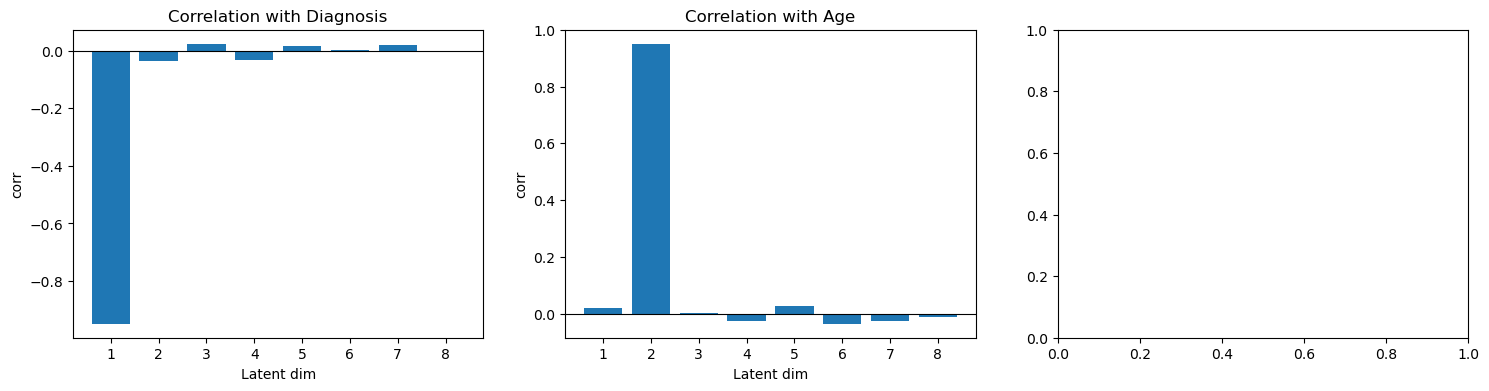

In [17]:
# Correlation per latent dimension with diagnosis and volume
corr_diag = []
corr_age = []
corr_vol = []
for d in range(X.shape[1]):
    # diagnosis correlation (mask valid)
    mask_d = diagnosis >= 0
    if np.any(mask_d):
        corr = np.corrcoef(X[mask_d, d], diagnosis[mask_d])[0, 1]
    else:
        corr = float('nan')
    corr_diag.append(corr)
    # age correlation (mask finite)
    mask_a = np.isfinite(age)
    if np.any(mask_a):
        corr = np.corrcoef(X[mask_a, d], age[mask_a])[0, 1]
    else:
        corr = float('nan')
    corr_age.append(corr)
    # volume correlation (mask finite)
    mask_v = np.isfinite(volume)
    if np.any(mask_v):
        corr = np.corrcoef(X[mask_v, d], volume[mask_v])[0, 1]
    else:
        corr = float('nan')
    corr_vol.append(corr)

fig, axes = plt.subplots(1, 3, figsize=(18, 4))
axes[0].bar(range(1, 9), corr_diag)
axes[0].set_title('Correlation with Diagnosis')
axes[0].set_xlabel('Latent dim')
axes[0].set_ylabel('corr')
axes[0].axhline(0, color='k', linewidth=0.8)

axes[1].bar(range(1, 9), corr_age)
axes[1].set_title('Correlation with Age')
axes[1].set_xlabel('Latent dim')
axes[1].set_ylabel('corr')
axes[1].axhline(0, color='k', linewidth=0.8)



In [ ]:
# Embeddings: PCA, ICA, NMF, FA, HLLE+ICA
X_std = StandardScaler().fit_transform(X)

results = {}

# PCA
pca = PCA(n_components=2)
results['PCA'] = pca.fit_transform(X_std)

# ICA
ica = FastICA(n_components=2, random_state=0)
results['ICA'] = ica.fit_transform(X_std)

# NMF (requires non-negative)
X_nn = MinMaxScaler().fit_transform(X)
nmf = NMF(n_components=2, init='nndsvda', random_state=0, max_iter=500)
results['NMF'] = nmf.fit_transform(X_nn)

# Factor Analysis
fa = FactorAnalysis(n_components=2, random_state=0)
results['FA'] = fa.fit_transform(X_std)

# HLLE + ICA (HLLE to 6D, then ICA to 2D)
try:
    hlle = LocallyLinearEmbedding(n_neighbors=10, n_components=6, method='hessian', eigen_solver='dense')
    Y_hlle = hlle.fit_transform(X_std)
    ica2 = FastICA(n_components=2, random_state=0)
    results['HLLE+ICA'] = ica2.fit_transform(Y_hlle)
except Exception as e:
    print('HLLE+ICA failed:', e)

# Plot embeddings colored by diagnosis and volume
fig, axes = plt.subplots(len(results), 2, figsize=(10, 4 * len(results)))
if len(results) == 1:
    axes = np.array([axes])
for i, (name, Y) in enumerate(results.items()):
    mask_d = diagnosis >= 0
    ax = axes[i, 0]
    sc = ax.scatter(Y[mask_d, 0], Y[mask_d, 1], c=diagnosis[mask_d], cmap='viridis', s=12)
    ax.set_title(f'{name} (Diagnosis)')
    plt.colorbar(sc, ax=ax)
    mask_v = np.isfinite(volume)
    ax = axes[i, 1]
    sc = ax.scatter(Y[mask_v, 0], Y[mask_v, 1], c=volume[mask_v], cmap='plasma', s=12)
    ax.set_title(f'{name} (Volume)')
    plt.colorbar(sc, ax=ax)
plt.tight_layout()
plt.show()


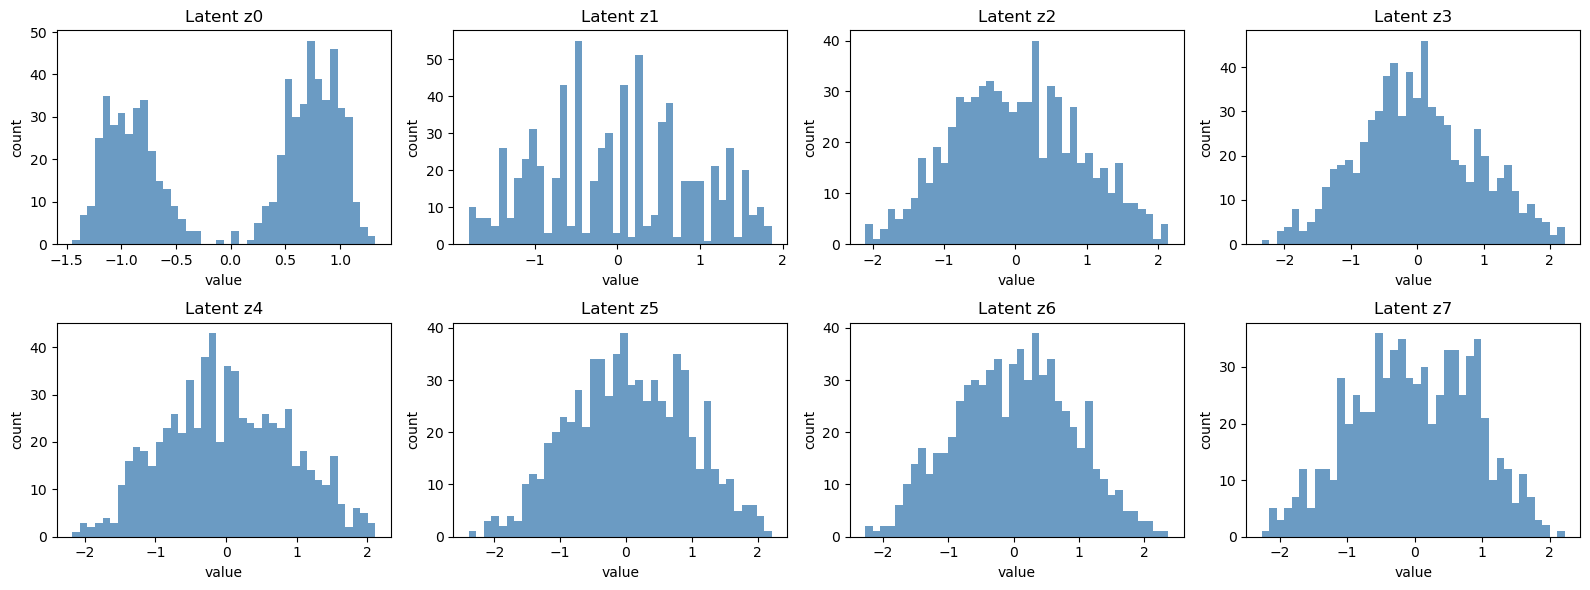

In [20]:
# Latent distributions for each of 8 variables
fig, axes = plt.subplots(2, 4, figsize=(16, 6))
axes = axes.flatten()
for i in range(8):
    ax = axes[i]
    ax.hist(X[:, i], bins=40, color='steelblue', alpha=0.8)
    ax.set_title(f'Latent z{i}')
    ax.set_xlabel('value')
    ax.set_ylabel('count')
plt.tight_layout()
plt.show()


## 8D Latent Analysis (Pseudo-Label Model, Real Labels for Analysis)
This repeats the 8D analysis for the **pseudo-label model**, but uses **real labels (labels.pt)** for diagnosis/volume.


In [24]:
# Latent stats + suggested sweep ranges (mean ± 3*std)
latents_8d = load_latents(EXPERIMENTS["real_label"])
meanv = latents_8d.mean(dim=0)
stdv = latents_8d.std(dim=0)
minv = latents_8d.min(dim=0).values
maxv = latents_8d.max(dim=0).values

print('dim | min | max | mean | std | mean±3std')
for d in range(latents_8d.shape[1]):
    m = float(meanv[d])
    s = float(stdv[d])
    mn = float(minv[d])
    mx = float(maxv[d])
    lo = m - 3*s
    hi = m + 3*s
    print(f'z{d}: {mn:+.4f} {mx:+.4f} {m:+.4f} {s:.4f}  [{lo:+.4f}, {hi:+.4f}]')

# Flag near-collapsed dims
tiny = (stdv < 1e-3).cpu().numpy()
print('Near-constant dims (std<1e-3):', np.where(tiny)[0].tolist())


dim | min | max | mean | std | mean±3std
z0: -1.4483 +1.3244 +0.0408 0.8636  [-2.5500, +2.6315]
z1: -1.7973 +1.8712 -0.0204 0.9177  [-2.7736, +2.7328]
z2: -2.1059 +2.1464 +0.0126 0.8811  [-2.6307, +2.6560]
z3: -2.3431 +2.2249 +0.0006 0.8876  [-2.6621, +2.6633]
z4: -2.1788 +2.1134 +0.0068 0.8729  [-2.6120, +2.6257]
z5: -2.3892 +2.2156 +0.0504 0.8910  [-2.6226, +2.7234]
z6: -2.2754 +2.3660 +0.0001 0.8835  [-2.6503, +2.6504]
z7: -2.2679 +2.2213 -0.0227 0.8900  [-2.6926, +2.6472]
Near-constant dims (std<1e-3): []


In [25]:
# Test decoder sensitivity: Δcode for z0 vs z1 on a real sample
import numpy as np

REAL_EXP = EXPERIMENTS["pseudo_label"]
specs_real, vae_real, sdf_dec_real, epoch_real = load_models(REAL_EXP, device)
vae_real.eval()

latents_8d = load_latents(REAL_EXP)

# pick a real sample (not mean)
idx = np.random.randint(0, latents_8d.shape[0])
z = latents_8d[idx].to(device).float()
print('Using sample idx:', idx)

def delta_code(z, dim, delta):
    z_plus = z.clone()
    z_minus = z.clone()
    z_plus[dim] += delta
    z_minus[dim] -= delta
    with torch.no_grad():
        c_plus = vae_real.decoder(z_plus.unsqueeze(0))
        c_minus = vae_real.decoder(z_minus.unsqueeze(0))
    return float(torch.norm(c_plus - c_minus, p=2).item())

deltas = [0.01, 0.05, 0.1, 0.2, 0.5]

print('Δcode(z0):')
for d in deltas:
    print(f'  Δ={d:.3f} -> {delta_code(z, 0, d):.6f}')

print('Δcode(z1):')
for d in deltas:
    print(f'  Δ={d:.3f} -> {delta_code(z, 1, d):.6f}')

# ratio at Δ=0.1 (if both computed)
try:
    dc0 = delta_code(z, 0, 0.1)
    dc1 = delta_code(z, 1, 0.1)
    print(f'Ratio Δcode(z0)/Δcode(z1) at Δ=0.1: {dc0/dc1:.4f}')
except Exception as e:
    print('Ratio compute failed:', e)


Using sample idx: 270
Δcode(z0):
  Δ=0.010 -> 0.009047
  Δ=0.050 -> 0.045220
  Δ=0.100 -> 0.090353
  Δ=0.200 -> 0.180094
  Δ=0.500 -> 0.444851
Δcode(z1):
  Δ=0.010 -> 0.006847
  Δ=0.050 -> 0.034230
  Δ=0.100 -> 0.068415
  Δ=0.200 -> 0.136482
  Δ=0.500 -> 0.335545
Ratio Δcode(z0)/Δcode(z1) at Δ=0.1: 1.3207


In [29]:
from tensorboard.backend.event_processing import event_accumulator

path = "examples/ADNI_1_L_No_MCI/MLP_VAE_SDF_disentangle_all_true_label/TensorBoard/events.out.tfevents.1769638023.aot.2701693.0"
ea = event_accumulator.EventAccumulator(path)
ea.Reload()

for tag in ["Metric/train_sensitivity_delta", "Loss/train_sensitivity"]:
    if tag in ea.Tags().get("scalars", []):
        events = ea.Scalars(tag)
        print(tag, "count", len(events))
        for ep in [100, 200, 400, 600, 800]:
            vals = [e.value for e in events if e.step == ep]
            print("  ep", ep, vals[0] if vals else None)
    else:
        print(tag, "missing")



Metric/train_sensitivity_delta count 2000
  ep 100 0.01867530681192875
  ep 200 0.0206997562199831
  ep 400 0.016835907474160194
  ep 600 0.01403067447245121
  ep 800 0.01240281667560339
Loss/train_sensitivity count 2000
  ep 100 0.0
  ep 200 0.0
  ep 400 0.0
  ep 600 0.0
  ep 800 0.0


## Compare `labels.pt` vs `normalized_labels.pt` (age + consistency)
This block loads the files from the spec, checks key/name alignment, compares non-age fields, and verifies age normalization on random samples.


In [ ]:
import os, json, random
import torch
import numpy as np

spec_path = 'examples/ADNI_1_L_No_MCI/MLP_VAE_SDF_disentangle_pseudo_label_only/specs.json'
with open(spec_path, 'r') as f:
    specs = json.load(f)

data_source = specs['DataSource']
labels_file = specs.get('LabelsFile', 'labels.pt')

raw_labels_path = os.path.join(data_source, 'labels.pt')
norm_labels_path = os.path.join(data_source, labels_file)

print('Raw labels:', raw_labels_path)
print('Normalized labels:', norm_labels_path)

raw_labels = torch.load(raw_labels_path)
norm_labels = torch.load(norm_labels_path)

# Helpers

def as_tensor(x):
    if isinstance(x, torch.Tensor):
        return x
    if isinstance(x, np.ndarray):
        return torch.from_numpy(x)
    if isinstance(x, (list, tuple)):
        return torch.tensor(x)
    return None

# Try to coerce labels to dict form

def to_dict(obj):
    if isinstance(obj, dict):
        return obj
    return None

raw_dict = to_dict(raw_labels)
norm_dict = to_dict(norm_labels)

if raw_dict is None or norm_dict is None:
    print('labels.pt or normalized_labels.pt is not a dict; cannot compare by name.')
else:
    raw_keys = set(raw_dict.keys())
    norm_keys = set(norm_dict.keys())
    print('Total in labels.pt:', len(raw_keys))
    print('Total in normalized_labels.pt:', len(norm_keys))
    print('Missing in normalized_labels.pt:', len(raw_keys - norm_keys))
    print('Missing in labels.pt:', len(norm_keys - raw_keys))

    common_keys = sorted(raw_keys & norm_keys)
    print('Common keys:', len(common_keys))

    # Detect age field
    def extract_age(val):
        # If dict with age-like keys
        if isinstance(val, dict):
            for k in ['age', 'Age', 'AGE']:
                if k in val:
                    return float(val[k]), ('dict', k)
        t = as_tensor(val)
        if t is None:
            return None, None
        t = t.flatten()
        if t.numel() >= 2:
            return float(t[1].item()), ('index', 1)
        return None, None

    # Determine age position from a sample
    sample_key = common_keys[0] if common_keys else None
    age_idx = None
    age_mode = None
    if sample_key is not None:
        age_raw, meta = extract_age(raw_dict[sample_key])
        if meta:
            age_mode = meta[0]
            if meta[0] == 'index':
                age_idx = meta[1]
        print('Age detection mode:', meta)
    else:
        print('No common keys to compare.')

    # Compare non-age fields (e.g., diagnosis) when tensors are available
    mismatch_other = 0
    checked_other = 0
    for k in common_keys:
        rv = as_tensor(raw_dict[k])
        nv = as_tensor(norm_dict[k])
        if rv is None or nv is None:
            continue
        rv = rv.flatten()
        nv = nv.flatten()
        if rv.numel() != nv.numel() or rv.numel() == 0:
            continue
        if age_idx is not None and age_idx < rv.numel():
            mask = torch.ones(rv.numel(), dtype=torch.bool)
            mask[age_idx] = False
            if mask.any():
                checked_other += 1
                if not torch.allclose(rv[mask], nv[mask], atol=1e-6, rtol=1e-6):
                    mismatch_other += 1
        else:
            # No age index detected; skip other-field compare
            pass

    if checked_other:
        print(f'Non-age field mismatches: {mismatch_other} / {checked_other}')

    # Build age arrays for normalization check
    ages = []
    norm_ages = []
    for k in common_keys:
        a, _ = extract_age(raw_dict[k])
        b, _ = extract_age(norm_dict[k])
        if a is None or b is None:
            continue
        ages.append(a)
        norm_ages.append(b)

    if ages:
        ages = np.array(ages, dtype=float)
        norm_ages = np.array(norm_ages, dtype=float)
        min_age, max_age = ages.min(), ages.max()
        denom = max_age - min_age if max_age > min_age else 1.0
        calc_norm = (ages - min_age) / denom

        # Print summary of normalization error
        err = np.abs(calc_norm - norm_ages)
        print('Age min/max:', min_age, max_age)
        print('Normalization abs error: mean={:.6f}, max={:.6f}'.format(err.mean(), err.max()))

        # Show 20 random examples
        sample_n = min(20, len(common_keys))
        sample_keys = random.sample(common_keys, sample_n)
        print('\nSample comparisons (name, age_raw, age_norm_file, age_norm_calc):')
        for k in sample_keys:
            a, _ = extract_age(raw_dict[k])
            b, _ = extract_age(norm_dict[k])
            if a is None or b is None:
                continue
            c = (a - min_age) / denom
            print(f'{k}: age={a:.4f}, norm_file={b:.4f}, norm_calc={c:.4f}')
    else:
        print('Could not extract ages from label files.')


In [ ]:
import os, json
import torch

spec_path = 'examples/ADNI_1_L_No_MCI/MLP_VAE_SDF_disentangle_pseudo_label_only/specs.json'
with open(spec_path, 'r') as f:
    specs = json.load(f)

data_source = specs['DataSource']
labels_file = specs.get('LabelsFile', 'labels.pt')

raw_labels_path = os.path.join(data_source, 'labels.pt')
norm_labels_path = os.path.join(data_source, labels_file)

raw_labels = torch.load(raw_labels_path)
norm_labels = torch.load(norm_labels_path)

print('Raw labels first 20:')
if isinstance(raw_labels, dict):
    for k in sorted(raw_labels.keys())[:20]:
        print(k, raw_labels[k])
else:
    for i, v in enumerate(raw_labels[:20]):
        print(i, v)

print('Normalized labels first 20:')
if isinstance(norm_labels, dict):
    for k in sorted(norm_labels.keys())[:20]:
        print(k, norm_labels[k])
else:
    for i, v in enumerate(norm_labels[:20]):
        print(i, v)


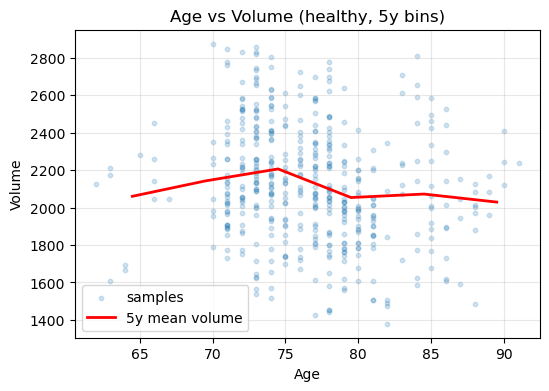

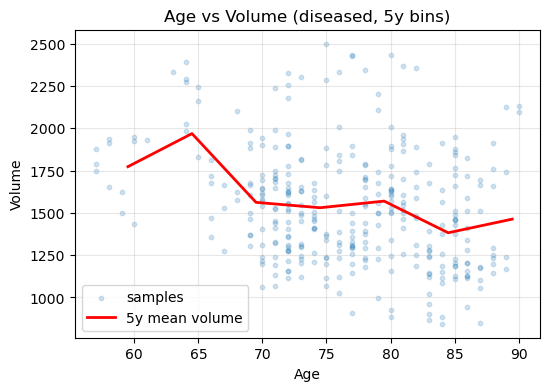

In [30]:
import os, json
import torch
import numpy as np
import matplotlib.pyplot as plt

spec_path = 'examples/ADNI_1_L_No_MCI/MLP_VAE_SDF_disentangle_pseudo_label_only/specs.json'
with open(spec_path, 'r') as f:
    specs = json.load(f)

data_source = specs['DataSource']
labels_file = specs.get('LabelsFile', 'labels.pt')

raw_labels_path = os.path.join(data_source, 'labels.pt')
labels_path = os.path.join(data_source, labels_file)

raw_labels = torch.load(raw_labels_path)
labels = torch.load(labels_path)

# Expect dict: name -> tensor([disease, age, volume?])
if not isinstance(raw_labels, dict) or not isinstance(labels, dict):
    print('labels.pt or normalized_labels.pt is not a dict; cannot plot by name.')
else:
    # Load latents if available from latest export (optional)
    # This assumes you have latents exported to a dict name->latent vector.
    latent_path = specs.get('TestLatentPath', None)
    latents = None
    if latent_path and os.path.exists(os.path.join(os.path.dirname(spec_path), latent_path)):
        try:
            latents = torch.load(os.path.join(os.path.dirname(spec_path), latent_path))
        except Exception:
            latents = None

    # Extract age and volume (raw) from labels.pt
    names = sorted(raw_labels.keys())
    ages = []
    volumes = []
    z0 = []
    z1 = []

    for name in names:
        rv = raw_labels[name]
        if isinstance(rv, torch.Tensor):
            rv = rv.flatten()
            if rv.numel() < 3:
                continue
            age = float(rv[1].item())
            vol = float(rv[-1].item())
        elif isinstance(rv, (list, tuple, np.ndarray)):
            rv = np.array(rv).reshape(-1)
            if rv.size < 3:
                continue
            age = float(rv[1])
            vol = float(rv[-1])
        else:
            continue
        ages.append(age)
        volumes.append(vol)

        if latents is not None and isinstance(latents, dict) and name in latents:
            zv = latents[name]
            if isinstance(zv, torch.Tensor):
                zv = zv.flatten()
                if zv.numel() >= 2:
                    z0.append(float(zv[0].item()))
                    z1.append(float(zv[1].item()))
                else:
                    z0.append(np.nan)
                    z1.append(np.nan)
            else:
                z0.append(np.nan)
                z1.append(np.nan)
        else:
            z0.append(np.nan)
            z1.append(np.nan)

    ages = np.array(ages)
    volumes = np.array(volumes)
    z0 = np.array(z0)
    z1 = np.array(z1)


    
    # Mean volume per 5-year age bins, split by disease label (index 0)
    disease = []
    for name in names:
        rv = raw_labels[name]
        if isinstance(rv, torch.Tensor):
            rv = rv.flatten()
            if rv.numel() < 2:
                disease.append(np.nan)
                continue
            disease.append(float(rv[0].item()))
        elif isinstance(rv, (list, tuple, np.ndarray)):
            rv = np.array(rv).reshape(-1)
            if rv.size < 2:
                disease.append(np.nan)
                continue
            disease.append(float(rv[0]))
        else:
            disease.append(np.nan)
    disease = np.array(disease)

    def plot_group(mask, title):
        if mask.sum() < 2:
            print(f'Not enough samples for {title}')
            return
        a = ages[mask]
        v = volumes[mask]
        # 5-year bins starting from floor(min age) to ceil(max age)
        age_min = np.floor(a.min())
        age_max = np.ceil(a.max())
        bins = np.arange(age_min, age_max + 5, 5)
        bin_centers = (bins[:-1] + bins[1:]) / 2.0
        mean_vol = []
        for lo, hi in zip(bins[:-1], bins[1:]):
            sel = (a >= lo) & (a < hi)
            if sel.any():
                mean_vol.append(v[sel].mean())
            else:
                mean_vol.append(np.nan)
        mean_vol = np.array(mean_vol)

        plt.figure(figsize=(6,4))
        plt.scatter(a, v, s=10, alpha=0.2, label='samples')
        plt.plot(bin_centers, mean_vol, color='red', linewidth=2, label='5y mean volume')
        plt.xlabel('Age')
        plt.ylabel('Volume')
        plt.title(title)
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()

    # Assuming disease labels are 0/1
    plot_group(disease == 0, 'Age vs Volume (healthy, 5y bins)')
    plot_group(disease == 1, 'Age vs Volume (diseased, 5y bins)')


'''

    # Volume vs z0/z1 if latents present
    if np.isfinite(z0).any():
        plt.figure(figsize=(6,4))
        plt.scatter(z0, volumes, s=10, alpha=0.6)
        plt.xlabel('z0')
        plt.ylabel('Volume')
        plt.title('z0 vs Volume')
        plt.grid(True, alpha=0.3)
        plt.show()

    if np.isfinite(z1).any():
        plt.figure(figsize=(6,4))
        plt.scatter(z1, volumes, s=10, alpha=0.6)
        plt.xlabel('z1')
        plt.ylabel('Volume')
        plt.title('z1 vs Volume')
        plt.grid(True, alpha=0.3)
        plt.show()
'''
    # Simple correlation summaries
def safe_corr(a, b):
    mask = np.isfinite(a) & np.isfinite(b)
    if mask.sum() < 2:
        return np.nan
    return np.corrcoef(a[mask], b[mask])[0,1]

    print('Corr(age, volume)=', safe_corr(ages, volumes))
    print('Corr(z0, volume)=', safe_corr(z0, volumes))
    print('Corr(z1, volume)=', safe_corr(z1, volumes))


Computing volume curve for z0 = min...


Computing volume curve for z0 = max...


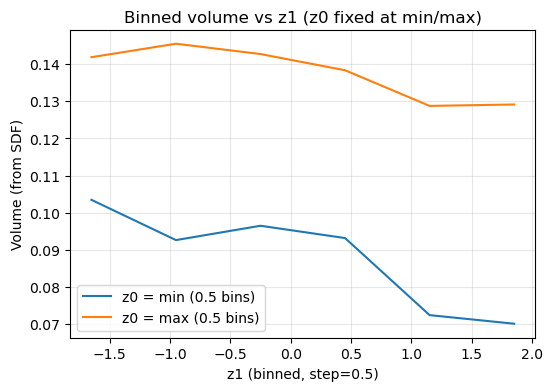

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Volume from SDF (shape) while sweeping z1; z0 fixed at min/max, others at mean
REAL_EXP = EXPERIMENTS["real_label"]
specs_real, vae_real, sdf_dec_real, epoch_real = load_models(REAL_EXP, device)
latents_8d = load_latents(REAL_EXP)
minv, maxv, meanv = latent_stats(latents_8d)

z0_min = float(minv[0].item())
z0_max = float(maxv[0].item())
z1_min = float(minv[1].item())
z1_max = float(maxv[1].item())

z1_grid = np.linspace(z1_min, z1_max, 20)

grid_n = 64  # increase to 128 for higher fidelity (slower)
max_batch = 32768


def volume_curve(z0_fixed):
    vols = []
    for z1_val in z1_grid:
        z = meanv.clone()
        z[0] = z0_fixed
        z[1] = float(z1_val)
        mesh, sdf_vals, voxel_origin, voxel_size = latent_to_mesh(
            z.tolist(), vae_real, sdf_dec_real, device, grid_n=grid_n, max_batch=max_batch, return_sdf=True
        )
        vol = volume_from_sdf(sdf_vals, voxel_size)
        vols.append(vol)
    return np.array(vols, dtype=float)

print('Computing volume curve for z0 = min...')
vol_min = volume_curve(z0_min)
print('Computing volume curve for z0 = max...')
vol_max = volume_curve(z0_max)

#plt.figure(figsize=(6,4))
#plt.plot(z1_grid, vol_min, label='z0 = min')
#plt.plot(z1_grid, vol_max, label='z0 = max')
#plt.xlabel('z1 (interpolated)')
#plt.ylabel('Volume (from SDF)')
#plt.title('Volume vs z1 (z0 fixed at min/max)')
#plt.grid(True, alpha=0.3)
#plt.legend()
#plt.show()


# Bin z1 in 0.5 steps and plot binned means
bin_step = 0.7
z1_bins = np.arange(np.floor(z1_min), np.ceil(z1_max) + bin_step, bin_step)
bin_centers = (z1_bins[:-1] + z1_bins[1:]) / 2.0

def bin_means(x, y, bins):
    out = []
    for lo, hi in zip(bins[:-1], bins[1:]):
        sel = (x >= lo) & (x < hi)
        out.append(np.mean(y[sel]) if np.any(sel) else np.nan)
    return np.array(out)

vol_min_b = bin_means(z1_grid, vol_min, z1_bins)
vol_max_b = bin_means(z1_grid, vol_max, z1_bins)

plt.figure(figsize=(6,4))
plt.plot(bin_centers, vol_min_b, label='z0 = min (0.5 bins)')
plt.plot(bin_centers, vol_max_b, label='z0 = max (0.5 bins)')
plt.xlabel('z1 (binned, step=0.5)')
plt.ylabel('Volume (from SDF)')
plt.title('Binned volume vs z1 (z0 fixed at min/max)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


In [ ]:
# Split distribution check (train / validation / test)
import os, json, random
import numpy as np
import torch
import matplotlib.pyplot as plt

# Point this to the experiment you want to analyze
SPEC_PATH = 'examples/ADNI_1_L_No_MCI/MLP_VAE_SDF_disentangle_pseudo_label_only/specs.json'
DISEASE_LABEL_INDEX = 0
AGE_LABEL_INDEX = 1
SEX_LABEL_INDEX = 2  # adjust if your labels use a different index

def _load_split_list(path):
    with open(path, 'r') as f:
        data = json.load(f)
    if isinstance(data, list):
        return data
    # common dict formats
    for key in ['files', 'npyfiles', 'split', 'train', 'test']:
        if key in data and isinstance(data[key], list):
            return data[key]
    # fallback: all values if dict of lists
    for v in data.values():
        if isinstance(v, list):
            return v
    raise ValueError(f'Unrecognized split file format: {path}')

def _base(name):
    return os.path.splitext(os.path.basename(name))[0]

with open(SPEC_PATH, 'r') as f:
    specs = json.load(f)

data_source = specs['DataSource']
labels_file = specs.get('LabelsFile', 'labels.pt')
labels_path = os.path.join(data_source, labels_file)
labels = torch.load(labels_path)
if not isinstance(labels, dict):
    raise ValueError('labels.pt must be a dict name->label vector for this analysis')

train_split_path = specs['TrainSplit']
test_split_path = specs.get('TestSplit', None)

train_list = _load_split_list(train_split_path)
test_list = _load_split_list(test_split_path) if test_split_path else []

# Validation split from TrainLatentHoldoutFraction (same as training script)
holdout_frac = float(specs.get('TrainLatentHoldoutFraction', 0.0))
holdout_seed = int(specs.get('TrainLatentHoldoutSeed', 0))
train_list = [p for p in train_list if _base(p) in labels]

val_list = []
if holdout_frac > 0.0:
    rng = random.Random(holdout_seed)
    idxs = list(range(len(train_list)))
    rng.shuffle(idxs)
    holdout_count = int(round(len(train_list) * holdout_frac))
    val_ids = set(idxs[:holdout_count])
    val_list = [train_list[i] for i in range(len(train_list)) if i in val_ids]
    train_list = [train_list[i] for i in range(len(train_list)) if i not in val_ids]

def _collect_labels(names):
    disease = []
    age = []
    sex = []
    missing = 0
    for name in names:
        key = _base(name)
        if key not in labels:
            missing += 1
            continue
        v = labels[key]
        if isinstance(v, torch.Tensor):
            v = v.flatten()
        else:
            v = torch.tensor(v).flatten()
        if v.numel() > DISEASE_LABEL_INDEX:
            disease.append(float(v[DISEASE_LABEL_INDEX].item()))
        if v.numel() > AGE_LABEL_INDEX:
            age.append(float(v[AGE_LABEL_INDEX].item()))
        if v.numel() > SEX_LABEL_INDEX:
            sex.append(float(v[SEX_LABEL_INDEX].item()))
    return np.array(disease), np.array(age), np.array(sex), missing

def _summarize_split(name, names):
    disease, age, sex, missing = _collect_labels(names)
    print(f'\n{name} split:')
    print('  total:', len(names), 'missing labels:', missing)
    if disease.size:
        vals, counts = np.unique(disease, return_counts=True)
        print('  disease (AD/CN) counts:', dict(zip(vals.tolist(), counts.tolist())))
    if age.size:
        print('  age: min={:.2f} max={:.2f} mean={:.2f} std={:.2f}'.format(
            float(age.min()), float(age.max()), float(age.mean()), float(age.std())))
    if sex.size:
        vals, counts = np.unique(sex, return_counts=True)
        print('  sex counts:', dict(zip(vals.tolist(), counts.tolist())))
    return disease, age, sex

train_d, train_a, train_s = _summarize_split('train', train_list)
val_d, val_a, val_s = _summarize_split('validation', val_list)
test_d, test_a, test_s = _summarize_split('test', test_list)

# Plot age distributions
plt.figure(figsize=(8,4))
if train_a.size: plt.hist(train_a, bins=20, alpha=0.5, label='train')
if val_a.size: plt.hist(val_a, bins=20, alpha=0.5, label='validation')
if test_a.size: plt.hist(test_a, bins=20, alpha=0.5, label='test')
plt.title('Age distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot disease distribution
plt.figure(figsize=(6,4))
labels_split = ['train','validation','test']
vals0 = [np.sum(train_d==0), np.sum(val_d==0), np.sum(test_d==0)]
vals1 = [np.sum(train_d==1), np.sum(val_d==1), np.sum(test_d==1)]
x = np.arange(3)
plt.bar(x-0.15, vals0, width=0.3, label='CN (0)')
plt.bar(x+0.15, vals1, width=0.3, label='AD (1)')
plt.xticks(x, labels_split)
plt.title('Disease distribution')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

# Plot sex distribution
plt.figure(figsize=(6,4))
vals0 = [np.sum(train_s==0), np.sum(val_s==0), np.sum(test_s==0)]
vals1 = [np.sum(train_s==1), np.sum(val_s==1), np.sum(test_s==1)]
plt.bar(x-0.15, vals0, width=0.3, label='Sex 0')
plt.bar(x+0.15, vals1, width=0.3, label='Sex 1')
plt.xticks(x, labels_split)
plt.title('Sex distribution')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()


In [ ]:
# Compare train/test/val latent distributions (sweep setting)
import os, json
import numpy as np
import torch
import matplotlib.pyplot as plt

# Base experiment (for CodeLength)
SPEC_PATH = 'examples/ADNI_1_L_No_MCI/minimal_eikonal_gmm_stratified_split/specs.json'
# Sweep setting folder with latents
LATENTS_DIR = 'examples/ADNI_1_L_No_MCI/minimal_eikonal_gmm_stratified_split/lambda_1e-3_iters_300'


def _load_latents_any(path):
    obj = torch.load(path, map_location='cpu')
    if isinstance(obj, dict):
        # support dict of name->latent or dict with 'latent_codes'
        if 'latent_codes' in obj:
            obj = obj['latent_codes']
        if isinstance(obj, dict):
            keys = sorted(obj.keys())
            obj = torch.stack([obj[k] for k in keys], dim=0)
    if isinstance(obj, torch.Tensor):
        if obj.dim() == 3 and obj.size(1) == 1:
            obj = obj[:, 0, :]
        return obj.float()
    raise ValueError('Unrecognized latent format')


with open(SPEC_PATH, 'r') as f:
    specs = json.load(f)

train_latent_path = os.path.join(LATENTS_DIR, 'train_latents', 'train_latents.pt')
test_latent_path = os.path.join(LATENTS_DIR, 'test_latents', 'test_latents.pt')
val_latent_path = os.path.join(LATENTS_DIR, 'val_latents', 'val_latents.pt')

print('Train latents:', train_latent_path)
print('Test latents :', test_latent_path)
print('Val latents  :', val_latent_path)

train_latents = _load_latents_any(train_latent_path)
test_latents = _load_latents_any(test_latent_path)
val_latents = _load_latents_any(val_latent_path)

print('Train shape:', tuple(train_latents.shape))
print('Test shape :', tuple(test_latents.shape))
print('Val shape  :', tuple(val_latents.shape))

# Ensure 2D latents with correct latent_dim
latent_dim = int(specs.get('CodeLength', 256))

def _ensure_2d(z):
    if z.dim() == 2:
        return z
    if z.dim() == 1 and z.numel() % latent_dim == 0:
        return z.view(-1, latent_dim)
    return z.view(-1, z.shape[-1])

train_latents = _ensure_2d(train_latents)
test_latents = _ensure_2d(test_latents)
val_latents = _ensure_2d(val_latents)

# Align latent dim if mismatched
min_dim = min(train_latents.shape[1], test_latents.shape[1], val_latents.shape[1])
if (train_latents.shape[1], test_latents.shape[1], val_latents.shape[1]) != (min_dim, min_dim, min_dim):
    print(f'Warning: latent dim mismatch -> using {min_dim}')
    train_latents = train_latents[:, :min_dim]
    test_latents = test_latents[:, :min_dim]
    val_latents = val_latents[:, :min_dim]


def summarize(name, z):
    z_np = z.numpy()
    print(f'\n{name} summary:')
    print('  global mean/std:', float(z_np.mean()), float(z_np.std()))
    print('  global min/max :', float(z_np.min()), float(z_np.max()))
    print('  per-dim mean abs:', float(np.mean(np.abs(z_np.mean(axis=0)))))
    print('  per-dim std avg :', float(np.mean(z_np.std(axis=0))))

summarize('Train', train_latents)
summarize('Test', test_latents)
summarize('Val', val_latents)

# Mean/Std deltas per dim (train vs test, train vs val)
mean_diff_tt = (train_latents.mean(dim=0) - test_latents.mean(dim=0)).numpy()
mean_diff_tv = (train_latents.mean(dim=0) - val_latents.mean(dim=0)).numpy()
std_diff_tt = (train_latents.std(dim=0) - test_latents.std(dim=0)).numpy()
std_diff_tv = (train_latents.std(dim=0) - val_latents.std(dim=0)).numpy()

abs_mean_diff = np.abs(mean_diff_tt) + np.abs(mean_diff_tv)
abs_std_diff = np.abs(std_diff_tt) + np.abs(std_diff_tv)

topk = min(10, abs_mean_diff.shape[0])
top_mean_idx = np.argsort(-abs_mean_diff)[:topk]
top_std_idx = np.argsort(-abs_std_diff)[:topk]

print('Top mean-diff dims (train vs test+val):')
for i in top_mean_idx:
    print(f'  z{i}: mean_diff_train-test={mean_diff_tt[i]:.4f}, mean_diff_train-val={mean_diff_tv[i]:.4f}')
print('Top std-diff dims (train vs test+val):')
for i in top_std_idx:
    print(f'  z{i}: std_diff_train-test={std_diff_tt[i]:.4f}, std_diff_train-val={std_diff_tv[i]:.4f}')

# Aggregate distance metrics
l2_mean_tt = float(np.linalg.norm(mean_diff_tt))
l2_mean_tv = float(np.linalg.norm(mean_diff_tv))
l2_std_tt = float(np.linalg.norm(std_diff_tt))
l2_std_tv = float(np.linalg.norm(std_diff_tv))
print('\nL2 distance of mean vectors: train-test', l2_mean_tt, 'train-val', l2_mean_tv)
print('L2 distance of std  vectors: train-test', l2_std_tt, 'train-val', l2_std_tv)

# Cosine similarity between mean vectors
mean_train = train_latents.mean(dim=0)
mean_test = test_latents.mean(dim=0)
mean_val = val_latents.mean(dim=0)

cos_tt = float((mean_train * mean_test).sum() / (mean_train.norm() * mean_test.norm() + 1e-8))
cos_tv = float((mean_train * mean_val).sum() / (mean_train.norm() * mean_val.norm() + 1e-8))
print('Mean vector cosine similarity: train-test', cos_tt, 'train-val', cos_tv)

# Histograms for top-k dims only (overlay)
topk_hist = min(12, top_mean_idx.shape[0])
cols = 4
rows = int(np.ceil(topk_hist / cols))
plt.figure(figsize=(4 * cols, 3 * rows))
for j, i in enumerate(top_mean_idx[:topk_hist]):
    plt.subplot(rows, cols, j + 1)
    plt.hist(train_latents[:, i].numpy(), bins=30, alpha=0.5, label='train')
    plt.hist(test_latents[:, i].numpy(), bins=30, alpha=0.5, label='test')
    plt.hist(val_latents[:, i].numpy(), bins=30, alpha=0.5, label='val')
    plt.title(f'z{i}')
    plt.grid(alpha=0.3)
    if j == 0:
        plt.legend()
plt.tight_layout()
plt.show()

# PCA 2D view (train/test/val)
try:
    from sklearn.decomposition import PCA
    Z = torch.cat([train_latents, test_latents, val_latents], dim=0).numpy()
    pca = PCA(n_components=2)
    Z2 = pca.fit_transform(Z)
    n_train = train_latents.shape[0]
    n_test = test_latents.shape[0]
    n_val = val_latents.shape[0]

    plt.figure(figsize=(6, 5))
    plt.scatter(Z2[:n_train, 0], Z2[:n_train, 1], s=8, alpha=0.5, label='train')
    plt.scatter(Z2[n_train:n_train + n_test, 0], Z2[n_train:n_train + n_test, 1], s=8, alpha=0.5, label='test')
    plt.scatter(Z2[n_train + n_test:, 0], Z2[n_train + n_test:, 1], s=8, alpha=0.5, label='val')
    plt.title('PCA of latents (train vs test vs val)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
except Exception as e:
    print('PCA plot skipped:', e)


In [ ]:
# Training latent statistics (from LatentCodes/latest.pth)
import os, json
import numpy as np
import torch

SPEC_PATH = 'examples/ADNI_1_L_No_MCI/minimal_eikonal_gmm/specs.json'

with open(SPEC_PATH, 'r') as f:
    specs = json.load(f)

exp_dir = os.path.dirname(SPEC_PATH)
latent_path = os.path.join(exp_dir, 'LatentCodes', 'latest.pth')
print('Training latent file:', latent_path)

obj = torch.load(latent_path, map_location='cpu')
if isinstance(obj, dict) and 'latent_codes' in obj:
    lat = obj['latent_codes']
else:
    lat = obj

# Convert OrderedDict / dict to tensor
if isinstance(lat, dict):
    keys = sorted(lat.keys())
    lat = torch.stack([lat[k] for k in keys], dim=0)

if isinstance(lat, torch.Tensor):
    if lat.dim() == 3 and lat.size(1) == 1:
        lat = lat[:, 0, :]
    # Fix shape (1, N, D) -> (N, D)
    if lat.dim() == 3 and lat.size(0) == 1:
        lat = lat[0]
    lat = lat.float()
else:
    raise ValueError('Unrecognized latent format')

print('Train latents shape:', tuple(lat.shape))

z_np = lat.numpy()
print('Train latents summary:')
print('  global mean/std:', float(z_np.mean()), float(z_np.std()))
print('  global min/max :', float(z_np.min()), float(z_np.max()))
print('  per-dim mean abs:', float(np.mean(np.abs(z_np.mean(axis=0)))))
print('  per-dim std avg :', float(np.mean(z_np.std(axis=0))))


In [12]:
# Show three real (GT) hippocampus meshes: healthy, middle volume, diseased (grayscale, upright)
import os
import numpy as np
import trimesh
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from deep_sdf import utils as sdf_utils

# Ensure real-label experiment objects are available
if 'specs_real' not in globals():
    REAL_EXP = EXPERIMENTS['real_label']
    specs_real, vae_real, sdf_dec_real, epoch_real = load_models(REAL_EXP, device)

# Build dataset filenames list to align indices with labels
if 'npz_filenames' not in globals():
    from deep_sdf import data as sdf_data
    split_path = specs_real['TrainSplit']
    with open(split_path, 'r') as f:
        split_json = json.load(f)
    npz_filenames = sdf_data.get_instance_filenames(specs_real['DataSource'], split_json)

# Load labels map if needed
if 'label_map' not in globals():
    mesh_root = specs_real['DataSourceMesh']
    labels_path = os.path.join(mesh_root, 'labels.pt')
    label_map = {}
    if os.path.exists(labels_path):
        all_labels = torch.load(labels_path, map_location='cpu')
        if isinstance(all_labels, dict):
            label_map = all_labels
        elif hasattr(all_labels, '__len__') and len(all_labels) == len(npz_filenames):
            for idx, filename in enumerate(npz_filenames):
                base_name = os.path.splitext(os.path.basename(filename))[0]
                label_map[base_name] = all_labels[idx]
        else:
            print('Warning: labels.pt not dict and length mismatch; label lookup disabled.')
    else:
        print(f'labels.pt not found at {labels_path}')

mesh_root = specs_real['DataSourceMesh']
mesh_ext = specs_real.get('EvalGTMeshExt', '.obj')

def mesh_path_from_base(base_name):
    return os.path.join(mesh_root, base_name + mesh_ext)

def _label_to_diag_vol(label):
    if label is None:
        return None, None
    try:
        diag = int(label[0].item()) if hasattr(label[0], 'item') else int(label[0])
        vol = None
        if hasattr(label, '__len__') and len(label) > 3:
            vol = float(label[3].item()) if hasattr(label[3], 'item') else float(label[3])
        return diag, vol
    except Exception:
        return None, None

def load_mesh(path):
    m = trimesh.load(path, force='mesh')
    m = sdf_utils.as_mesh(m)
    return m

records = []
for npz_path in npz_filenames:
    base_name = os.path.splitext(os.path.basename(npz_path))[0]
    label = label_map.get(base_name) if isinstance(label_map, dict) else None
    diag, vol = _label_to_diag_vol(label)
    if diag is None or vol is None:
        continue
    mesh_path = mesh_path_from_base(base_name)
    if not os.path.isfile(mesh_path):
        continue
    records.append({
        'mesh_path': mesh_path,
        'diagnosis': diag,
        'volume': vol,
    })

if not records:
    raise RuntimeError('No labeled meshes found to display. Check mesh_root/labels alignment.')

# Pick middle from healthy only (by volume)
healthy_sorted = sorted([r for r in records if r['diagnosis'] == 0], key=lambda r: r['volume'])
if not healthy_sorted:
    raise RuntimeError('No healthy meshes found for middle pick.')
mid_pick = healthy_sorted[len(healthy_sorted)//2]

# Healthy and diseased extremes (by label volume)
healthy = [r for r in records if r['diagnosis'] == 0]
diseased = [r for r in records if r['diagnosis'] == 1]

if not healthy or not diseased:
    raise RuntimeError('Could not find both healthy and diseased meshes.')

healthy_pick = max(healthy, key=lambda r: r['volume'])
diseased_pick = min(diseased, key=lambda r: r['volume'])

m_healthy = load_mesh(healthy_pick['mesh_path'])
m_mid = load_mesh(mid_pick['mesh_path'])
m_diseased = load_mesh(diseased_pick['mesh_path'])

def upright_vertices(mesh):
    v = mesh.vertices.copy()
    # Rotate +90 deg around X so Z becomes up (swap Y/Z).
    v = np.stack([v[:, 0], v[:, 2], -v[:, 1]], axis=1)
    # Center and put on ground plane
    v = v - v.mean(axis=0, keepdims=True)
    v[:, 2] -= v[:, 2].min()
    return v

def mesh_to_plot(mesh, color='#9e9e9e', opacity=1.0, upright=True):
    v = upright_vertices(mesh) if upright else mesh.vertices
    f = mesh.faces
    return go.Mesh3d(
        x=v[:, 0], y=v[:, 1], z=v[:, 2],
        i=f[:, 0], j=f[:, 1], k=f[:, 2],
        color=color, opacity=opacity,
        lighting=dict(ambient=0.7, diffuse=0.6, specular=0.2, roughness=0.7, fresnel=0.1),
        lightposition=dict(x=1.2, y=1.2, z=2.0),
        showscale=False,
    )

healthy_title = 'Healthy (mesh vol={:.2f})'.format(float(m_healthy.volume))
mid_title = 'Middle (mesh vol={:.2f})'.format(float(m_mid.volume))
diseased_title = 'Diseased (mesh vol={:.2f})'.format(float(m_diseased.volume))

fig = make_subplots(
    rows=1, cols=3,
    specs=[[{'type': 'scene'}, {'type': 'scene'}, {'type': 'scene'}]],
    subplot_titles=(healthy_title, mid_title, diseased_title),
)

# All same color
mesh_color = '#9e9e9e'

fig.add_trace(mesh_to_plot(m_healthy, color=mesh_color), row=1, col=1)
fig.add_trace(mesh_to_plot(m_mid, color=mesh_color), row=1, col=2)
fig.add_trace(mesh_to_plot(m_diseased, color=mesh_color), row=1, col=3)

fig.update_layout(
    height=600,
    margin=dict(l=0, r=0, b=0, t=40),
    scene=dict(xaxis=dict(visible=False), yaxis=dict(visible=False), zaxis=dict(visible=False), aspectmode='data'),
    scene2=dict(xaxis=dict(visible=False), yaxis=dict(visible=False), zaxis=dict(visible=False), aspectmode='data'),
    scene3=dict(xaxis=dict(visible=False), yaxis=dict(visible=False), zaxis=dict(visible=False), aspectmode='data'),
)

fig.show()


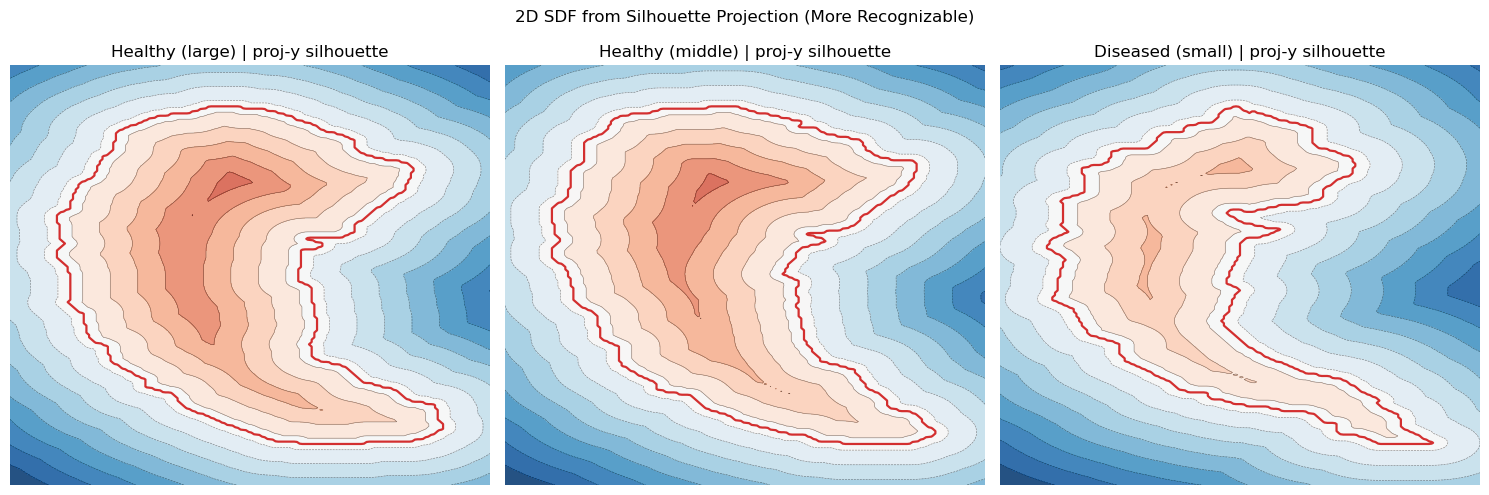

In [9]:
# 2D silhouette SDF (projection) for three real hippocampus meshes
import os
import json
import torch
import numpy as np
import trimesh
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from deep_sdf import utils as sdf_utils

try:
    from scipy.ndimage import distance_transform_edt
except Exception:
    distance_transform_edt = None

# Reuse meshes if already loaded
if not all(name in globals() for name in ['m_healthy', 'm_mid', 'm_diseased']):
    if 'specs_real' not in globals():
        REAL_EXP = EXPERIMENTS['real_label']
        specs_real, vae_real, sdf_dec_real, epoch_real = load_models(REAL_EXP, device)

    if 'npz_filenames' not in globals():
        from deep_sdf import data as sdf_data
        split_path = specs_real['TrainSplit']
        with open(split_path, 'r') as f:
            split_json = json.load(f)
        npz_filenames = sdf_data.get_instance_filenames(specs_real['DataSource'], split_json)

    if 'label_map' not in globals():
        mesh_root = specs_real['DataSourceMesh']
        labels_path = os.path.join(mesh_root, 'labels.pt')
        label_map = {}
        if os.path.exists(labels_path):
            all_labels = torch.load(labels_path, map_location='cpu')
            if isinstance(all_labels, dict):
                label_map = all_labels
            elif hasattr(all_labels, '__len__') and len(all_labels) == len(npz_filenames):
                for idx, filename in enumerate(npz_filenames):
                    base_name = os.path.splitext(os.path.basename(filename))[0]
                    label_map[base_name] = all_labels[idx]
        else:
            print(f'labels.pt not found at {labels_path}')

    mesh_root = specs_real['DataSourceMesh']
    mesh_ext = specs_real.get('EvalGTMeshExt', '.obj')

    def mesh_path_from_base(base_name):
        return os.path.join(mesh_root, base_name + mesh_ext)

    def _label_to_diag_vol(label):
        if label is None:
            return None, None
        try:
            diag = int(label[0].item()) if hasattr(label[0], 'item') else int(label[0])
            vol = None
            if hasattr(label, '__len__') and len(label) > 3:
                vol = float(label[3].item()) if hasattr(label[3], 'item') else float(label[3])
            return diag, vol
        except Exception:
            return None, None

    def load_mesh(path):
        m = trimesh.load(path, force='mesh')
        m = sdf_utils.as_mesh(m)
        return m

    records = []
    for npz_path in npz_filenames:
        base_name = os.path.splitext(os.path.basename(npz_path))[0]
        label = label_map.get(base_name) if isinstance(label_map, dict) else None
        diag, vol = _label_to_diag_vol(label)
        if diag is None or vol is None:
            continue
        mesh_path = mesh_path_from_base(base_name)
        if not os.path.isfile(mesh_path):
            continue
        records.append({
            'mesh_path': mesh_path,
            'diagnosis': diag,
            'volume': vol,
        })

    healthy = [r for r in records if r['diagnosis'] == 0]
    diseased = [r for r in records if r['diagnosis'] == 1]
    healthy_sorted = sorted(healthy, key=lambda r: r['volume'])
    mid_pick = healthy_sorted[len(healthy_sorted)//2]
    healthy_pick = max(healthy, key=lambda r: r['volume'])
    diseased_pick = min(diseased, key=lambda r: r['volume'])

    m_healthy = load_mesh(healthy_pick['mesh_path'])
    m_mid = load_mesh(mid_pick['mesh_path'])
    m_diseased = load_mesh(diseased_pick['mesh_path'])

def upright_vertices(mesh):
    v = mesh.vertices.copy()
    v = np.stack([v[:, 0], v[:, 2], -v[:, 1]], axis=1)
    v = v - v.mean(axis=0, keepdims=True)
    return v

def best_projection_axis(v):
    areas = []
    for axis in [0, 1, 2]:
        a_idx, b_idx = [i for i in range(3) if i != axis]
        area = (v[:, a_idx].max() - v[:, a_idx].min()) * (v[:, b_idx].max() - v[:, b_idx].min())
        areas.append(area)
    return int(np.argmax(areas))

def silhouette_sdf(mesh, grid_n=180, pad=0.12):
    if distance_transform_edt is None:
        raise RuntimeError('scipy is required for distance_transform_edt')

    v = upright_vertices(mesh)
    m = trimesh.Trimesh(vertices=v, faces=mesh.faces, process=False)
    axis = best_projection_axis(v)
    a_idx, b_idx = [i for i in range(3) if i != axis]

    a_min, a_max = v[:, a_idx].min(), v[:, a_idx].max()
    b_min, b_max = v[:, b_idx].min(), v[:, b_idx].max()
    ar = a_max - a_min
    br = b_max - b_min

    a_min -= pad * ar
    a_max += pad * ar
    b_min -= pad * br
    b_max += pad * br

    a_vals = np.linspace(a_min, a_max, grid_n)
    b_vals = np.linspace(b_min, b_max, grid_n)
    aa, bb = np.meshgrid(a_vals, b_vals)

    origins = np.zeros((aa.size, 3), dtype=np.float32)
    origins[:, a_idx] = aa.ravel()
    origins[:, b_idx] = bb.ravel()

    # start rays just before the mesh on the projection axis
    axis_min = v[:, axis].min()
    axis_max = v[:, axis].max()
    origin_axis = axis_min - 0.2 * (axis_max - axis_min)
    origins[:, axis] = origin_axis

    directions = np.zeros_like(origins)
    directions[:, axis] = 1.0

    # Ray test for silhouette occupancy (projection)
    try:
        from trimesh.ray.ray_pyembree import RayMeshIntersector
        intersector = RayMeshIntersector(m)
        hits = intersector.intersects_any(origins, directions)
    except Exception:
        hits = m.ray.intersects_any(origins, directions)

    inside = hits.reshape(grid_n, grid_n)

    # Distance transform in 2D (pixel units -> real units via sampling)
    da = (a_max - a_min) / float(grid_n - 1)
    db = (b_max - b_min) / float(grid_n - 1)

    dist_out = distance_transform_edt(~inside, sampling=(db, da))
    dist_in = distance_transform_edt(inside, sampling=(db, da))
    sdf = dist_out
    sdf[inside] = -dist_in[inside]

    return sdf, a_vals, b_vals, axis

meshes = [m_healthy, m_mid, m_diseased]
titles = [
    'Healthy (large)',
    'Healthy (middle)',
    'Diseased (small)',
]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
cmap = 'RdBu_r'

for ax, mesh, title in zip(axes, meshes, titles):
    sdf, a_vals, b_vals, axis = silhouette_sdf(mesh, grid_n=180, pad=0.12)
    # Flip sign so inside is positive (red) and outside negative (blue)
    sdf = -sdf
    max_abs = float(np.nanmax(np.abs(sdf)))
    levels = np.linspace(-max_abs, max_abs, 18)
    norm = TwoSlopeNorm(vmin=-max_abs, vcenter=0.0, vmax=max_abs)
    im = ax.contourf(a_vals, b_vals, sdf, levels=levels, cmap=cmap, norm=norm, alpha=0.9)
    ax.contour(a_vals, b_vals, sdf, levels=levels, colors='k', linewidths=0.4, alpha=0.5)
    ax.contour(a_vals, b_vals, sdf, levels=[0.0], colors='#d32f2f', linewidths=1.6)
    ax.set_title('{} | proj-{} silhouette'.format(title, ['x','y','z'][axis]))
    ax.set_axis_off()

fig.suptitle('2D SDF from Silhouette Projection (More Recognizable)')
plt.tight_layout()
plt.show()


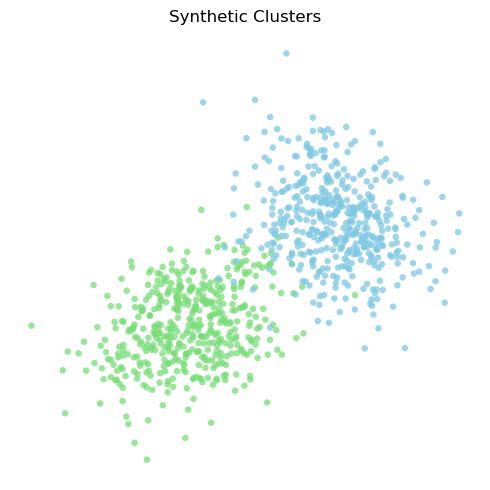

In [5]:
# Synthetic 2D clusters (light green + light blue)
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(7)

n = 450
# Cluster A (green)
mean_a = np.array([0.0, 0.0])
cov_a = np.array([[0.6, 0.15], [0.15, 0.4]])
A = np.random.multivariate_normal(mean_a, cov_a, size=n)

# Cluster B (blue)
mean_b = np.array([2.4, 1.6])
cov_b = np.array([[0.5, -0.1], [-0.1, 0.45]])
B = np.random.multivariate_normal(mean_b, cov_b, size=n)

fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(A[:, 0], A[:, 1], s=22, c='#77DD77', alpha=0.75, edgecolors='none')
ax.scatter(B[:, 0], B[:, 1], s=22, c='#7EC8E3', alpha=0.75, edgecolors='none')

# Light, clean styling for embedding in a figure
ax.set_aspect('equal', 'box')
ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_title('Synthetic Clusters', pad=8)
plt.tight_layout()
plt.show()


In [ ]:
# --- Batch render z1 interpolation views (z0=min/max) ---
import numpy as np
from pathlib import Path
import plotly.graph_objects as go
import inspect

# Pick experiment
exp_name = "pseudo_label"
exp = experiments[exp_name]

print(f'Using experiment: {exp_name}')

# Settings
z0_dim = 0
z1_dim = 1
grid_n = 128
max_batch = 131072
num_steps = 4
yellow_boost = 1.8  # increase if you want stronger yellow
_has_boost = 'boost' in inspect.signature(intensity_from_diff_grid).parameters

# Match the default camera from the last UI cell
#left 
default_eye = dict(x=0.2, y=-0.2, z=-1.4)
#default_eye = dict(x=-0.1, y=0.5, z=-1.4)
default_up = dict(x=0.0, y=-1.0, z=0.0)

# z1 interpolation
z1_min = float(exp['minv'][z1_dim].item())
z1_max = float(exp['maxv'][z1_dim].item())
z1_vals = np.linspace(z1_min, z1_max, num_steps)

output_root = Path('outputs/z1_interpolation_views_pseudo_right') / exp_name
output_root.mkdir(parents=True, exist_ok=True)

views = [
    ('front', default_eye),  # use same camera as last UI cell
]

def _save_figure(fig, png_path):
    png_path = Path(png_path)
    html_path = png_path.with_suffix('.html')
    wrote_png = False
    try:
        fig.write_image(str(png_path), scale=2)
        wrote_png = True
    except Exception as exc:
        print(f'Could not write image {png_path}: {exc}')
    try:
        fig.write_html(str(html_path))
    except Exception as exc:
        print(f'Could not write HTML {html_path}: {exc}')
    if not wrote_png:
        print(f'PNG not written; HTML saved to {html_path}')


def _render_mesh(mesh, ranges, eye, out_path, intensity=None, title=None, up=None):
    v = _prepare_vertices(mesh, upright=False)
    f = mesh.faces
    if intensity is None:
        trace = go.Mesh3d(
            x=v[:, 0], y=v[:, 1], z=v[:, 2],
            i=f[:, 0], j=f[:, 1], k=f[:, 2],
            color='#1f77b4', opacity=1.0,
        )
    else:
        trace = go.Mesh3d(
            x=v[:, 0], y=v[:, 1], z=v[:, 2],
            i=f[:, 0], j=f[:, 1], k=f[:, 2],
            intensity=intensity,
            colorscale=[
                [0.0, '#1f77b4'],
                [0.5, '#FFF3A0'],
                [1.0, '#FFC107'],
            ],
            cmin=0.0,
            cmax=1.0,
            showscale=False,
            opacity=1.0,
        )

    if up is None:
        up = default_up

    xr, yr, zr = ranges
    fig = go.Figure(trace)
    fig.update_layout(
        title=title,
        margin=dict(l=0, r=0, b=0, t=30),
        scene=dict(
            xaxis=dict(visible=False, range=xr),
            yaxis=dict(visible=False, range=yr),
            zaxis=dict(visible=False, range=zr),
            aspectmode='cube',
            camera=dict(eye=eye, up=up),
        ),
    )
    _save_figure(fig, out_path)

meanv = exp['meanv']
for step_idx, z1_val in enumerate(z1_vals):
    base = [float(v.item()) for v in meanv]
    base[z1_dim] = float(z1_val)

    z_max = base.copy()
    z_max[z0_dim] = float(exp['maxv'][z0_dim].item())

    z_min = base.copy()
    z_min[z0_dim] = float(exp['minv'][z0_dim].item())

    max_mesh, max_sdf, origin, voxel = latent_to_mesh(
        z_max, exp['vae'], exp['sdf_decoder'], device,
        grid_n=grid_n, max_batch=max_batch, return_sdf=True,
    )
    min_mesh, min_sdf, _, _ = latent_to_mesh(
        z_min, exp['vae'], exp['sdf_decoder'], device,
        grid_n=grid_n, max_batch=max_batch, return_sdf=True,
    )

    if max_mesh is None or min_mesh is None or max_sdf is None or min_sdf is None:
        print(f'Skipping z1={z1_val:.4f} (mesh generation failed).')
        continue

    diff = np.abs(min_sdf - max_sdf)
    denom = float(np.max(diff)) if diff is not None else None
    if _has_boost:
        intensity = intensity_from_diff_grid(
            min_mesh, diff, origin, voxel, denom=denom, boost=yellow_boost
        )
    else:
        intensity = intensity_from_diff_grid(
            min_mesh, diff, origin, voxel, denom=denom
        )
    if intensity is None:
        intensity = np.zeros((min_mesh.vertices.shape[0],), dtype=np.float32)

    center, r = _center_and_radius_from_meshes([min_mesh, max_mesh], upright=False)
    ranges = (
        [float(center[0] - r), float(center[0] + r)],
        [float(center[1] - r), float(center[1] + r)],
        [float(center[2] - r), float(center[2] + r)],
    )

    tag = f'z1_{step_idx:02d}_{z1_val:.4f}'
    safe_tag = tag.replace('-', 'm').replace('.', 'p')
    z_dir = output_root / safe_tag
    min_dir = z_dir / 'z0_min'
    max_dir = z_dir / 'z0_max'
    min_dir.mkdir(parents=True, exist_ok=True)
    max_dir.mkdir(parents=True, exist_ok=True)

    for view_name, eye in views:
        _render_mesh(
            max_mesh, ranges, eye,
            max_dir / f'{view_name}.png',
            intensity=None,
            title=f'{exp_name} z1={z1_val:.4f} z0=max ({view_name})',
            up=default_up,
        )
        _render_mesh(
            min_mesh, ranges, eye,
            min_dir / f'{view_name}.png',
            intensity=intensity,
            title=f'{exp_name} z1={z1_val:.4f} z0=min ({view_name})',
            up=default_up,
        )

print('Done. Output root:', output_root)


In [10]:
def _slider_step(minv, maxv):
    span = float(maxv - minv)
    if span <= 0:
        return 0.01
    return span / 200.0


def build_experiment_ui(name, exp, default_grid=None):
    import inspect
    import math

    latent_dim = exp["latent_dim"]
    minv = exp["minv"]
    maxv = exp["maxv"]
    meanv = exp["meanv"]

    _has_show_change = "show_change_map" in inspect.signature(build_baselines_and_change_figure).parameters

    # Convention used in this notebook: z0 ~ disease, z1 ~ age.
    disease_dim = 0
    disease_min = float(minv[disease_dim].item())
    disease_max = float(maxv[disease_dim].item())
    name_lower = str(name).lower()
    is_pseudo = ("pseudo" in name_lower) or ("psudo" in name_lower)
    baseline_left_name = "max" if is_pseudo else "min"
    baseline_right_name = "min" if is_pseudo else "max"
    change_ref_name = "min" if is_pseudo else "max"
    baseline_titles = (
        f"Baseline: z{disease_dim} {baseline_left_name}",
        f"Baseline: z{disease_dim} {baseline_right_name}",
    )
    change_title = (
        f"Current: change map (vs z{disease_dim} {change_ref_name}; "
        f"blue=no change, yellow=more change)"
    )

    sliders = []
    for i in range(latent_dim):
        zmin = float(minv[i].item())
        zmax = float(maxv[i].item())
        step = _slider_step(zmin, zmax)

        # Start at disease-max so moving toward min shows a clean progression.
        default_value = float(meanv[i].item())
        if i == disease_dim:
            default_value = zmax

        slider = FloatSlider(
            value=default_value,
            min=zmin,
            max=zmax,
            step=step,
            description=f"z{i}",
            continuous_update=False,
            readout_format=".4f",
            layout={"width": "350px"},
        )
        sliders.append(slider)

    if default_grid is None:
        default_grid = 64 if device.type == "cuda" else 32

    grid_slider = IntSlider(
        value=default_grid,
        min=32,
        max=128,
        step=16,
        description="Grid N",
        continuous_update=False,
        layout={"width": "350px"},
    )
    batch_slider = IntSlider(
        value=32768 if device.type == "cuda" else 8192,
        min=8192,
        max=131072,
        step=8192,
        description="Max batch",
        continuous_update=False,
        layout={"width": "350px"},
    )

    default_eye = dict(x=0.0, y=1.0, z=-1.4)
    default_up = dict(x=0.0, y=-1.0, z=0.0)

    camera_eye_x = FloatSlider(
        value=default_eye["x"],
        min=-5.0,
        max=5.0,
        step=0.1,
        description="Eye X",
        continuous_update=False,
        layout={"width": "350px"},
    )
    camera_eye_y = FloatSlider(
        value=default_eye["y"],
        min=-5.0,
        max=5.0,
        step=0.1,
        description="Eye Y",
        continuous_update=False,
        layout={"width": "350px"},
    )
    camera_eye_z = FloatSlider(
        value=default_eye["z"],
        min=-5.0,
        max=5.0,
        step=0.1,
        description="Eye Z",
        continuous_update=False,
        layout={"width": "350px"},
    )
    camera_up_x = FloatSlider(
        value=default_up["x"],
        min=-1.0,
        max=1.0,
        step=0.1,
        description="Up X",
        continuous_update=False,
        layout={"width": "350px"},
    )
    camera_up_y = FloatSlider(
        value=default_up["y"],
        min=-1.0,
        max=1.0,
        step=0.1,
        description="Up Y",
        continuous_update=False,
        layout={"width": "350px"},
    )
    camera_up_z = FloatSlider(
        value=default_up["z"],
        min=-1.0,
        max=1.0,
        step=0.1,
        description="Up Z",
        continuous_update=False,
        layout={"width": "350px"},
    )

    auto_update = Checkbox(value=False, description="Auto update")
    upright = Checkbox(value=False, description="Upright mesh")
    show_change = Checkbox(value=True, description="Show change map")
    change_boost = 1.3  # increase to push deeper yellow
    render_btn = Button(description="Render", button_style="primary")
    reset_btn = Button(description="Reset to mean")
    reset_cam_btn = Button(description="Reset camera")

    out = Output()
    fig_widget = None
    fig_upright = None

    base_min_mesh = None
    base_min_sdf = None
    base_max_mesh = None
    base_max_sdf = None
    base_origin = None
    base_voxel = None
    base_grid_n = None
    base_min_volume = None
    base_max_volume = None
    change_denom = None
    camera_min_dist = None

    volume_label = Label(value="Volume: N/A")
    hint_label = Label(
        value=(
            f"Baselines: z{disease_dim} {baseline_left_name}/{baseline_right_name}. "
            f"Change map vs z{disease_dim} {change_ref_name} "
            f"(blue=no change, yellow=more change)."
        )
    )

    # Baseline latents: mean everywhere except disease dim at min/max.
    base_z_min = [float(v.item()) for v in meanv]
    base_z_min[disease_dim] = disease_min
    base_z_max = [float(v.item()) for v in meanv]
    base_z_max[disease_dim] = disease_max

    def _ensure_baselines(grid_n):
        nonlocal base_min_mesh, base_min_sdf, base_max_mesh, base_max_sdf
        nonlocal base_origin, base_voxel, base_grid_n, base_min_volume, base_max_volume
        nonlocal change_denom, fig_widget

        if base_grid_n == grid_n and base_min_mesh is not None and base_max_mesh is not None:
            return

        base_min_mesh, base_min_sdf, base_origin, base_voxel = latent_to_mesh(
            base_z_min,
            exp["vae"],
            exp["sdf_decoder"],
            device,
            grid_n=grid_n,
            max_batch=batch_slider.value,
            return_sdf=True,
        )
        base_min_volume = volume_from_sdf(base_min_sdf, base_voxel)

        base_max_mesh, base_max_sdf, _, _ = latent_to_mesh(
            base_z_max,
            exp["vae"],
            exp["sdf_decoder"],
            device,
            grid_n=grid_n,
            max_batch=batch_slider.value,
            return_sdf=True,
        )
        base_max_volume = volume_from_sdf(base_max_sdf, base_voxel)

        ref_diff = np.abs(base_max_sdf - base_min_sdf)
        # Stable normalization so min->max progression doesn't rescale colors each update.
        change_denom = float(np.max(ref_diff)) if ref_diff is not None else None
        if change_denom is None or not np.isfinite(change_denom) or change_denom <= 1e-8:
            change_denom = 1.0

        base_grid_n = grid_n
        fig_widget = None  # force rebuild (ranges/topology may change with grid)

    def _sanitize_vec(x, y, z, default, min_norm=1e-3):
        norm = math.sqrt(x * x + y * y + z * z)
        if not math.isfinite(norm) or norm < min_norm:
            return dict(x=default["x"], y=default["y"], z=default["z"])
        return dict(x=x, y=y, z=z)

    def _apply_camera():
        if fig_widget is None:
            return
        eye = _sanitize_vec(camera_eye_x.value, camera_eye_y.value, camera_eye_z.value, default_eye, min_norm=0.2)
        if camera_min_dist is not None:
            norm = math.sqrt(eye["x"] * eye["x"] + eye["y"] * eye["y"] + eye["z"] * eye["z"])
            if norm < camera_min_dist:
                scale = camera_min_dist / max(norm, 1e-6)
                eye = dict(x=eye["x"] * scale, y=eye["y"] * scale, z=eye["z"] * scale)
        camera_up = _sanitize_vec(camera_up_x.value, camera_up_y.value, camera_up_z.value, default_up, min_norm=1e-3)
        camera = dict(
            eye=eye,
            up=camera_up,
            center=dict(x=0.0, y=0.0, z=0.0),
        )
        fig_widget.update_layout(
            scene_camera=camera,
            scene2_camera=camera,
            scene3_camera=camera,
        )

    def on_camera_change(change):
        _apply_camera()

    def render(_=None):
        nonlocal fig_widget, fig_upright, camera_min_dist
        with out:
            grid_n = grid_slider.value
            is_upright = upright.value

            _ensure_baselines(grid_n)

            # Current mesh/SDF for current z.
            show_change_map = show_change.value
            z = [s.value for s in sliders]
            cur_mesh, cur_sdf, _, _ = latent_to_mesh(
                z,
                exp["vae"],
                exp["sdf_decoder"],
                device,
                grid_n=grid_n,
                max_batch=batch_slider.value,
                return_sdf=True,
            )

            if cur_mesh is None or base_min_mesh is None or base_max_mesh is None:
                out.clear_output(wait=True)
                print("No mesh generated (marching cubes failed).")
                return

            center, r = _center_and_radius_from_meshes([base_min_mesh, base_max_mesh, cur_mesh], upright=is_upright)
            camera_min_dist = max(2.0 * float(r), 1.0)

            if show_change_map:
                ref_sdf = base_min_sdf if is_pseudo else base_max_sdf
                diff_cur = np.abs(cur_sdf - ref_sdf)
                intensity = intensity_from_diff_grid(
                    cur_mesh,
                    diff_cur,
                    base_origin,
                    base_voxel,
                    denom=change_denom,
                )
                if intensity is not None:
                    intensity = np.clip(intensity * change_boost, 0.0, 1.0)
            else:
                intensity = np.zeros((cur_mesh.vertices.shape[0],), dtype=np.float32)

            title = f"{name} (epoch {exp['epoch']})"

            if fig_widget is None or fig_upright != is_upright:
                out.clear_output(wait=True)
                build_kwargs = dict(
                    title=title,
                    upright=is_upright,
                    camera_z=camera_eye_z.value,
                )
                if _has_show_change:
                    build_kwargs["show_change_map"] = show_change_map
                baseline_left_mesh = base_max_mesh if is_pseudo else base_min_mesh
                baseline_right_mesh = base_min_mesh if is_pseudo else base_max_mesh
                build_kwargs["baseline_titles"] = baseline_titles
                build_kwargs["change_title"] = change_title
                build_kwargs["baseline_left_mesh"] = baseline_left_mesh
                build_kwargs["baseline_right_mesh"] = baseline_right_mesh
                fig_widget = build_baselines_and_change_figure(
                    base_min_mesh,
                    base_max_mesh,
                    cur_mesh,
                    intensity,
                    **build_kwargs,
                )
                fig_upright = is_upright
                display_plotly(fig_widget)
            else:
                update_kwargs = dict(title=title, upright=is_upright)
                if "show_change_map" in inspect.signature(update_change_figure).parameters:
                    update_kwargs["show_change_map"] = show_change_map
                update_change_figure(fig_widget, cur_mesh, intensity, **update_kwargs)
                if not _HAS_ANYWIDGET:
                    out.clear_output(wait=True)
                    display_plotly(fig_widget)

            _apply_camera()

            # Volume
            vol = volume_from_sdf(cur_sdf, base_voxel)
            if vol is None or base_min_volume is None or base_max_volume is None:
                volume_label.value = "Volume: N/A"
            else:
                ref_vol = base_min_volume if is_pseudo else base_max_volume
                dvol = vol - ref_vol
                if is_pseudo:
                    volume_label.value = (
                        f"Volume: {vol:.4f} (Δvs z{disease_dim} {change_ref_name} {dvol:+.4f})  "
                        f"[max={base_max_volume:.4f}, min={base_min_volume:.4f}]"
                    )
                else:
                    volume_label.value = (
                        f"Volume: {vol:.4f} (Δvs z{disease_dim} {change_ref_name} {dvol:+.4f})  "
                        f"[min={base_min_volume:.4f}, max={base_max_volume:.4f}]"
                    )

    def on_slider_change(change):
        if auto_update.value:
            render()

    def on_reset_camera(_):
        camera_eye_x.value = default_eye["x"]
        camera_eye_y.value = default_eye["y"]
        camera_eye_z.value = default_eye["z"]
        camera_up_x.value = default_up["x"]
        camera_up_y.value = default_up["y"]
        camera_up_z.value = default_up["z"]
        _apply_camera()

    def on_reset(_):
        for i, s in enumerate(sliders):
            s.value = float(meanv[i].item())
        sliders[disease_dim].value = disease_max
        if auto_update.value:
            render()

    for s in sliders:
        s.observe(on_slider_change, names="value")
    grid_slider.observe(on_slider_change, names="value")
    batch_slider.observe(on_slider_change, names="value")
    upright.observe(on_slider_change, names="value")
    show_change.observe(lambda change: render(), names="value")

    camera_eye_x.observe(on_camera_change, names="value")
    camera_eye_y.observe(on_camera_change, names="value")
    camera_eye_z.observe(on_camera_change, names="value")
    camera_up_x.observe(on_camera_change, names="value")
    camera_up_y.observe(on_camera_change, names="value")
    camera_up_z.observe(on_camera_change, names="value")

    render_btn.on_click(render)
    reset_btn.on_click(on_reset)
    reset_cam_btn.on_click(on_reset_camera)

    controls = VBox(
        [
            Label(value=f"Experiment: {exp['exp_dir']}"),
            hint_label,
            HBox([render_btn, reset_btn, reset_cam_btn, auto_update, upright, show_change]),
            volume_label,
            grid_slider,
            batch_slider,
            Label(value="Camera (eye / up)"),
            camera_eye_x,
            camera_eye_y,
            camera_eye_z,
            camera_up_x,
            camera_up_y,
            camera_up_z,
            VBox(sliders),
        ]
    )
    ui = VBox([controls, out])
    render()
    return ui


tabs_children = []
tab_titles = []
for name, exp in experiments.items():
    tabs_children.append(build_experiment_ui(name, exp))
    tab_titles.append(name)

if tabs_children:
    from ipywidgets import Tab

    tabs = Tab(children=tabs_children)
    for i, t in enumerate(tab_titles):
        tabs.set_title(i, t)
    display(tabs)
else:
    print("No experiments loaded. Check EXPERIMENTS paths.")


In [ ]:
# --- Batch render z1 interpolation views (z0=min/max) --- [max colored]
import numpy as np
from pathlib import Path
import plotly.graph_objects as go
import inspect

# Pick experiment
exp_name = "pseudo_label"
exp = experiments[exp_name]

print(f'Using experiment: {exp_name}')

# Settings
z0_dim = 0
z1_dim = 1
grid_n = 128
max_batch = 131072
num_steps = 4
yellow_boost = 1.8  # increase if you want stronger yellow
_has_boost = 'boost' in inspect.signature(intensity_from_diff_grid).parameters

# Match the default camera from the last UI cell
#left 
default_eye = dict(x=0.2, y=-0.2, z=-1.4)
#default_eye = dict(x=-0.1, y=0.5, z=-1.4)
default_up = dict(x=0.0, y=-1.0, z=0.0)

# z1 interpolation
z1_min = float(exp['minv'][z1_dim].item())
z1_max = float(exp['maxv'][z1_dim].item())
z1_vals = np.linspace(z1_min, z1_max, num_steps)

output_root = Path('outputs/z1_interpolation_views_pseudo_right') / exp_name
output_root.mkdir(parents=True, exist_ok=True)

views = [
    ('front', default_eye),  # use same camera as last UI cell
]

def _save_figure(fig, png_path):
    png_path = Path(png_path)
    html_path = png_path.with_suffix('.html')
    wrote_png = False
    try:
        fig.write_image(str(png_path), scale=2)
        wrote_png = True
    except Exception as exc:
        print(f'Could not write image {png_path}: {exc}')
    try:
        fig.write_html(str(html_path))
    except Exception as exc:
        print(f'Could not write HTML {html_path}: {exc}')
    if not wrote_png:
        print(f'PNG not written; HTML saved to {html_path}')


def _render_mesh(mesh, ranges, eye, out_path, intensity=None, title=None, up=None):
    v = _prepare_vertices(mesh, upright=False)
    f = mesh.faces
    if intensity is None:
        trace = go.Mesh3d(
            x=v[:, 0], y=v[:, 1], z=v[:, 2],
            i=f[:, 0], j=f[:, 1], k=f[:, 2],
            color='#1f77b4', opacity=1.0,
        )
    else:
        trace = go.Mesh3d(
            x=v[:, 0], y=v[:, 1], z=v[:, 2],
            i=f[:, 0], j=f[:, 1], k=f[:, 2],
            intensity=intensity,
            colorscale=[
                [0.0, '#1f77b4'],
                [0.5, '#FFF3A0'],
                [1.0, '#FFC107'],
            ],
            cmin=0.0,
            cmax=1.0,
            showscale=False,
            opacity=1.0,
        )

    if up is None:
        up = default_up

    xr, yr, zr = ranges
    fig = go.Figure(trace)
    fig.update_layout(
        title=title,
        margin=dict(l=0, r=0, b=0, t=30),
        scene=dict(
            xaxis=dict(visible=False, range=xr),
            yaxis=dict(visible=False, range=yr),
            zaxis=dict(visible=False, range=zr),
            aspectmode='cube',
            camera=dict(eye=eye, up=up),
        ),
    )
    _save_figure(fig, out_path)

meanv = exp['meanv']
for step_idx, z1_val in enumerate(z1_vals):
    base = [float(v.item()) for v in meanv]
    base[z1_dim] = float(z1_val)

    z_max = base.copy()
    z_max[z0_dim] = float(exp['maxv'][z0_dim].item())

    z_min = base.copy()
    z_min[z0_dim] = float(exp['minv'][z0_dim].item())

    max_mesh, max_sdf, origin, voxel = latent_to_mesh(
        z_max, exp['vae'], exp['sdf_decoder'], device,
        grid_n=grid_n, max_batch=max_batch, return_sdf=True,
    )
    min_mesh, min_sdf, _, _ = latent_to_mesh(
        z_min, exp['vae'], exp['sdf_decoder'], device,
        grid_n=grid_n, max_batch=max_batch, return_sdf=True,
    )

    if max_mesh is None or min_mesh is None or max_sdf is None or min_sdf is None:
        print(f'Skipping z1={z1_val:.4f} (mesh generation failed).')
        continue

    diff = np.abs(min_sdf - max_sdf)
    denom = float(np.max(diff)) if diff is not None else None
    if _has_boost:
        intensity = intensity_from_diff_grid(
            max_mesh, diff, origin, voxel, denom=denom, boost=yellow_boost
        )
    else:
        intensity = intensity_from_diff_grid(
            max_mesh, diff, origin, voxel, denom=denom
        )
    if intensity is None:
        intensity = np.zeros((max_mesh.vertices.shape[0],), dtype=np.float32)

    center, r = _center_and_radius_from_meshes([min_mesh, max_mesh], upright=False)
    ranges = (
        [float(center[0] - r), float(center[0] + r)],
        [float(center[1] - r), float(center[1] + r)],
        [float(center[2] - r), float(center[2] + r)],
    )

    tag = f'z1_{step_idx:02d}_{z1_val:.4f}'
    safe_tag = tag.replace('-', 'm').replace('.', 'p')
    z_dir = output_root / safe_tag
    min_dir = z_dir / 'z0_min'
    max_dir = z_dir / 'z0_max'
    min_dir.mkdir(parents=True, exist_ok=True)
    max_dir.mkdir(parents=True, exist_ok=True)

    for view_name, eye in views:
        _render_mesh(
            max_mesh, ranges, eye,
            max_dir / f'{view_name}.png',
            intensity=intensity,
            title=f'{exp_name} z1={z1_val:.4f} z0=max ({view_name})',
            up=default_up,
        )
        _render_mesh(
            min_mesh, ranges, eye,
            min_dir / f'{view_name}.png',
            intensity=None,
            title=f'{exp_name} z1={z1_val:.4f} z0=min ({view_name})',
            up=default_up,
        )

print('Done. Output root:', output_root)
